# Mini Projeto de Redes Neurais

### Grupo 1

#### Gabriel de Melo Evangelista - gme@cin.ufpe.br
#### Maria Luísa Leandro de Lima - mlll@cin.ufpe.br
#### Vinícius Sales Oliveira - vso2@cin.ufpe.br

### Valores a serem testados nos modelos


Os valores abaixo foram escolhidos pela equipe para o estudo das melhorias/perdas de desempenho dos modelos MLP e CNN

#### MLP
- Tamanho da rede: [1 - 4]
- Taxa de aprendizagem: [0.001 - 0.01]
- Função de ativação: [relu, softmax, tanh, sigmoid]
- Algoritmo de aprendizagem: [adam, rmsprop, sgd]
- Dropout: [0.2 - 0.7]

#### CNN
- Tamanho da rede [1 - 3]
- Dropout [0.2 - 0.7]
- Janela [3, 5 e 7]
- Stride [1 - 3]

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Tratamento de dados e imports

### Imports

Utilizamos as bibliotecas Tensorflow e Keras em Python para implementação dos modelos MLP e CNN, além da biblioteca Numpy para operações matemáticas e Scikit-Learn para funções de métricas de avaliação.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### Download dos dados MNIST

O banco de dados MNIST foi obtido a partir da biblioteca Keras

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


### Parâmetros e hiperparâmetros

Principais parâmetros que serão utilizados na normalização dos dados e em seu treinamento.

In [ ]:
input_shape = x_train[0].shape # Formato de entrada a ser aceito pela primeira camada dos modelos
num_class = 10 # Numero de classes existentes no dataset
batch_size = 32 # Numero de amostras por iteração de treinamento
epochs = 10 # Numero de vezes que o modelo treinara no conjunto completo de treinamento
val_split = 0.3 # Porcentagem do conjunto de treino a ser usado para a validacao
verbose = 0 # parametro para modificar os detalhes a serem mostrados durante o treinamento

### Normalização dos dados

- Aplicamos a função reshape nos dados para garantir que todas imagens tem a mesma dimensão.
- Dividimos por $255$ para normalização (uma vez que os valores estão no intervalo $[0,255]$)

In [ ]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))/255.
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))/255.

### Categorização das labels

Utilizamos a função $to\_categorical$ para transformar as $N$ categorias das amostras em vetores de tamanho $N$ contendo o valor $1$ apenas na coluna correspondente à categoria da amostra (todas as outras colunas possuem o valor $0$).

In [ ]:
y_train = to_categorical(y_train, num_class)
y_test = to_categorical(y_test, num_class)

## Matriz de confusão e gráficos

In [ ]:
def historyPlot(model, history_dict, y_test):
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  accuracy = history_dict['accuracy']
  val_accuracy = history_dict['val_accuracy']
  
  epochs = range(1, len(loss_values) + 1)
  fig, ax = plt.subplots(1, 2, figsize=(14, 6))

  ax[0].plot(epochs, accuracy, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
  ax[0].set_title('Training & Validation Accuracy', fontsize=16)
  ax[0].set_xlabel('Epochs', fontsize=16)
  ax[0].set_ylabel('Accuracy', fontsize=16)
  ax[0].legend()

  ax[1].plot(epochs, loss_values, 'bo', label='Training loss')
  ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
  ax[1].set_title('Training & Validation Loss', fontsize=16)
  ax[1].set_xlabel('Epochs', fontsize=16)
  ax[1].set_ylabel('Loss', fontsize=16)
  ax[1].legend()
  
  y_test_argmax = np.argmax(y_test, axis=1) 
  y_pred = model.predict(x_test)
  y_pred_argmax = np.argmax(y_pred, axis=1)
  print(classification_report(y_test_argmax, y_pred_argmax))
  
  cm = confusion_matrix(y_test_argmax, y_pred_argmax, labels = np.unique(y_test_argmax))
  cmd = ConfusionMatrixDisplay(cm, display_labels = np.unique(y_test_argmax))
  cmd.plot()
  plt.show()

  var = cm.diagonal()/cm.sum(axis=1) 
  print("Accuracy")
  _ = [print( "Label " + str(i) + (": {percentage:.2f} %").format(percentage=100*var[i])) for i in range(len(var))]

In [ ]:
def networkExperiment(model,x_train = x_train,shape = input_shape,num_class = num_class, y_train = y_train, x_test = x_test, y_test = y_test, batch_size = batch_size,epochs = epochs, validation_split = val_split, verbose = verbose, optimizer = 'adam'):
  model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = 'accuracy')
  history_model = model.fit(x_train, y_train, batch_size = batch_size, validation_split = val_split, epochs = epochs, verbose = verbose)
  eval = model.evaluate(x_test, y_test)
  return eval, history_model

## Estudo MLP

### Tamanho da rede
#### Valores a serem testados: $1, 2, 3$ ou $4$ camadas

Primeiramente iremos analisar a influência do tamanho da rede na acurácia e no loss do modelo. Todos os modelos terão uma camada densa de saída de 10 unidades.

Criamos $4$ modelos:
 

1.   Apenas a camada simples
2.   Camada densa com $100$ unidades
3.   Camada densa com $200$ unidades $+$ camada densa com $100$ unidades
4.   Camada densa com $200$ unidades $+$ camada densa com $100$ unidades $+$ camada densa com $50$ unidades



In [ ]:
model_MLP_1 = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(num_class, activation = 'softmax')                     
])

In [ ]:
model_MLP_2 = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(100, activation = 'softmax'), 
     layers.Dense(num_class, activation = 'softmax')                     
])

In [ ]:
model_MLP_3 = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(200, activation = 'softmax'), 
     layers.Dense(100, activation = 'softmax'), 
     layers.Dense(num_class, activation = 'softmax')                     
])

In [ ]:
model_MLP_4 = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(200, activation = 'softmax'), 
     layers.Dense(100, activation = 'softmax'), 
     layers.Dense(50, activation = 'softmax'), 
     layers.Dense(num_class, activation = 'softmax')                     
])

Para todos os modelos utilizamos o otimizador Adam, a métrica acurácia e a função de perda $categorical\_crossentropy$ 

313/313 [==============================] - 1s 3ms/step - loss: 0.2682 - accuracy: 0.9259
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.92      0.90      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.90      0.88      0.89       892
           6       0.94      0.95      0.95       958
           7       0.91      0.94      0.92      1028
           8       0.88      0.90      0.89       974
           9       0.94      0.87      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



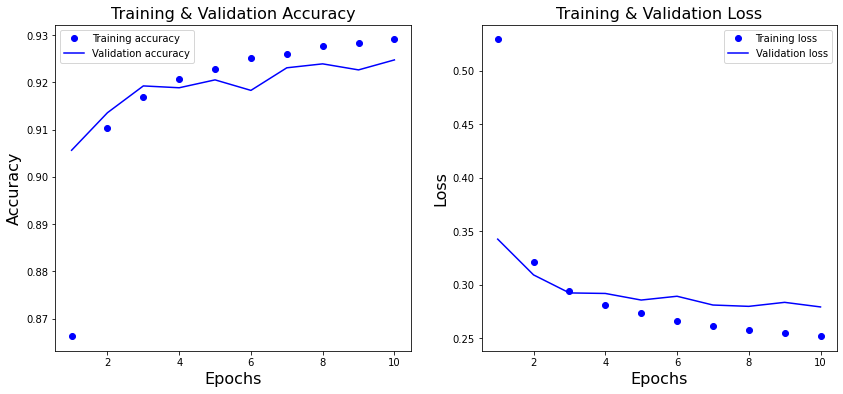

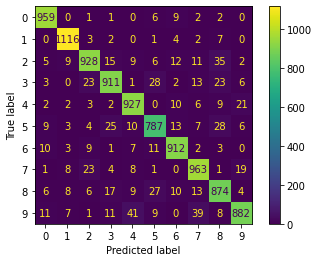

Accuracy
Label 0: 97.86 %
Label 1: 98.33 %
Label 2: 89.92 %
Label 3: 90.20 %
Label 4: 94.40 %
Label 5: 88.23 %
Label 6: 95.20 %
Label 7: 93.68 %
Label 8: 89.73 %
Label 9: 87.41 %


In [ ]:
eval_1, history_1 = networkExperiment(model_MLP_1)
historyPlot(model_MLP_1, history_1.history, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2468 - accuracy: 0.9365
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.98      1135
           2       0.94      0.91      0.93      1032
           3       0.89      0.93      0.91      1010
           4       0.94      0.94      0.94       982
           5       0.96      0.89      0.92       892
           6       0.95      0.95      0.95       958
           7       0.96      0.91      0.94      1028
           8       0.89      0.93      0.91       974
           9       0.91      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



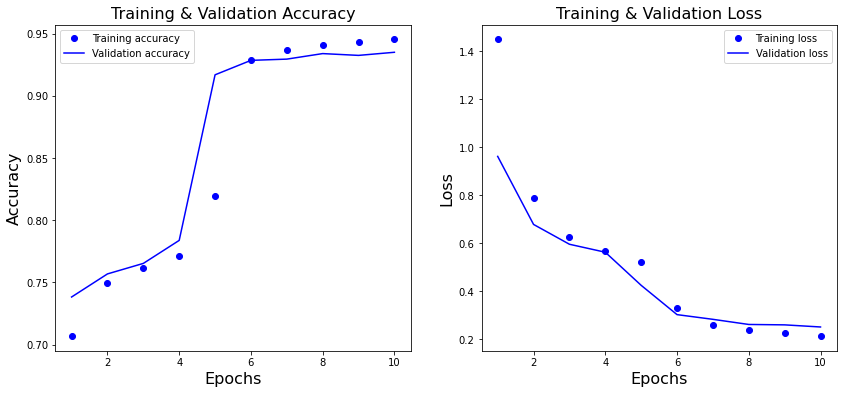

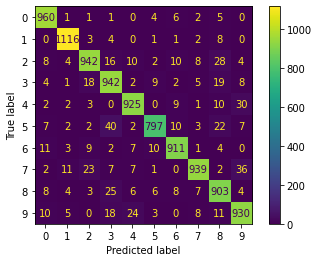

Accuracy
Label 0: 97.96 %
Label 1: 98.33 %
Label 2: 91.28 %
Label 3: 93.27 %
Label 4: 94.20 %
Label 5: 89.35 %
Label 6: 95.09 %
Label 7: 91.34 %
Label 8: 92.71 %
Label 9: 92.17 %


In [ ]:
eval_2, history_2 = networkExperiment(model_MLP_2)
historyPlot(model_MLP_2, history_2.history, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.2251 - accuracy: 0.9428
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.93      0.95      0.94      1032
           3       0.88      0.95      0.91      1010
           4       0.96      0.93      0.94       982
           5       0.95      0.89      0.92       892
           6       0.96      0.96      0.96       958
           7       0.96      0.93      0.94      1028
           8       0.94      0.92      0.93       974
           9       0.93      0.93      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



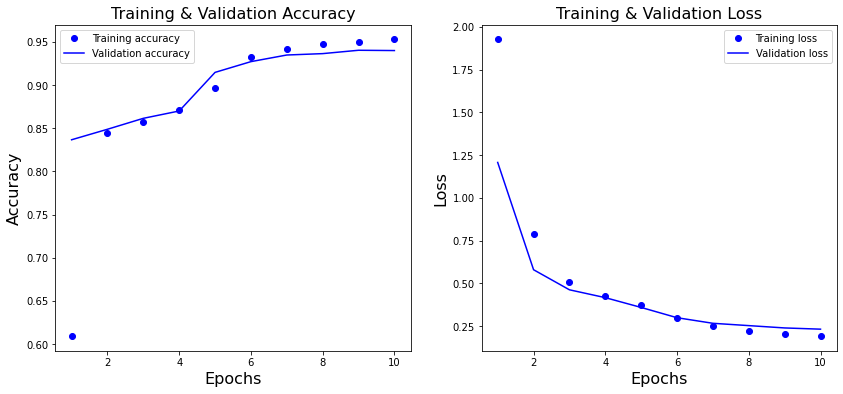

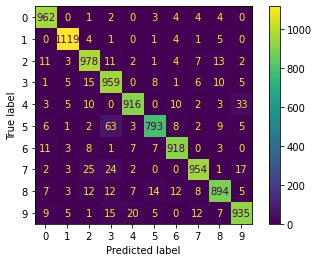

Accuracy
Label 0: 98.16 %
Label 1: 98.59 %
Label 2: 94.77 %
Label 3: 94.95 %
Label 4: 93.28 %
Label 5: 88.90 %
Label 6: 95.82 %
Label 7: 92.80 %
Label 8: 91.79 %
Label 9: 92.67 %


In [ ]:
eval_3, history_3 = networkExperiment(model_MLP_3)
historyPlot(model_MLP_3, history_3.history, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9333 - accuracy: 0.6010


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.80      0.96      0.87       980
           1       0.52      0.97      0.68      1135
           2       0.42      0.07      0.12      1032
           3       0.67      0.69      0.68      1010
           4       0.50      0.96      0.66       982
           5       0.65      0.64      0.65       892
           6       0.48      0.84      0.61       958
           7       0.00      0.00      0.00      1028
           8       0.88      0.85      0.86       974
           9       0.40      0.05      0.09      1009

    accuracy                           0.60     10000
   macro avg       0.53      0.60      0.52     10000
weighted avg       0.53      0.60      0.52     10000



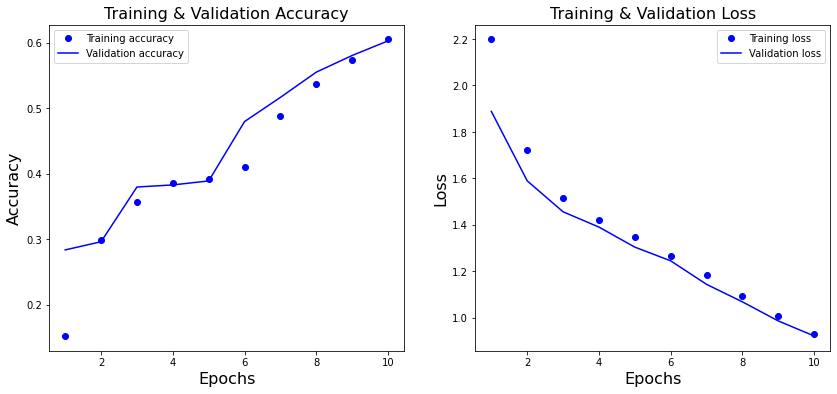

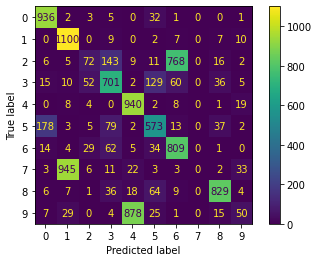

Accuracy
Label 0: 95.51 %
Label 1: 96.92 %
Label 2: 6.98 %
Label 3: 69.41 %
Label 4: 95.72 %
Label 5: 64.24 %
Label 6: 84.45 %
Label 7: 0.00 %
Label 8: 85.11 %
Label 9: 4.96 %


In [ ]:
eval_4, history_4 = networkExperiment(model_MLP_4)
historyPlot(model_MLP_4, history_4.history, y_test)

#### Resultados

In [ ]:
print(("Tamanho 1 | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_1[0], percentage1=100*(eval_1[1])))
print(("Tamanho 2 | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_2[0], percentage1=100*(eval_2[1])))
print(("Tamanho 3 | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_3[0], percentage1=100*(eval_3[1])))
print(("Tamanho 4 | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_4[0], percentage1=100*(eval_4[1])))

Tamanho 1 | Accuracy: 92.59 % | Loss: 0.27
Tamanho 2 | Accuracy: 93.65 % | Loss: 0.25
Tamanho 3 | Accuracy: 94.28 % | Loss: 0.23
Tamanho 4 | Accuracy: 60.10 % | Loss: 0.93


A análise dos resultados desse experimento mostra que com o aumento do número de camadas, a acurácia aumenta e o loss diminui gradativamente mas a partir de 4 camadas a acurácia cai e o loss aumenta muito. O modelo com 3 camadas se observa a tendência de redução do loss e uma acurácia mais alta.

Além disso, ocorre diminuição da acurácia, precisão e do recall a partir da do modelo de 4 camadas o que indica um overfitting.

Vale mencionar que a época em que o valor da função loss na etapa de validação ultrapassa o valor na etapa de treino aumenta com o aumento do tamanho da rede, pois por inserir mais camadas, a rede se torna mais complexa e menos sensível a atualizações.

### Taxa de aprendizagem
#### Valores a serem testados: $0.001$ a $0.01$ com passo $0.001$

Analisaremos agora o impacto da taxa de aprendizagem, para isso compilaremos $1$ modelo básico descrito abaixo $10$ vezes modificando apenas a taxa de aprendizagem de $0.001$ a $0.01$ com passo $0.001$.

A taxa de aprendizagem atual é 0.001
313/313 [==============================] - 1s 3ms/step - loss: 0.3912 - accuracy: 0.8647
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.93      0.92      0.92      1032
           3       0.59      0.85      0.70      1010
           4       0.93      0.94      0.93       982
           5       0.89      0.88      0.88       892
           6       0.92      0.96      0.94       958
           7       0.87      0.95      0.91      1028
           8       0.72      0.30      0.42       974
           9       0.91      0.86      0.88      1009

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.85     10000
weighted avg       0.87      0.86      0.86     10000



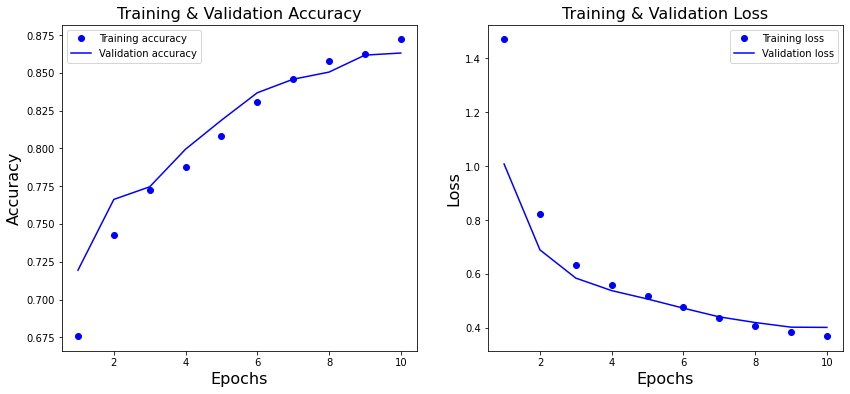

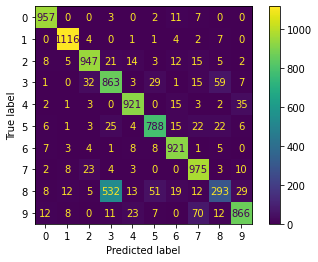

Accuracy
Label 0: 97.65 %
Label 1: 98.33 %
Label 2: 91.76 %
Label 3: 85.45 %
Label 4: 93.79 %
Label 5: 88.34 %
Label 6: 96.14 %
Label 7: 94.84 %
Label 8: 30.08 %
Label 9: 85.83 %
A taxa de aprendizagem atual é 0.002
313/313 [==============================] - 1s 3ms/step - loss: 0.2747 - accuracy: 0.9253
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.92      0.93      1032
           3       0.89      0.93      0.91      1010
           4       0.94      0.90      0.92       982
           5       0.89      0.90      0.90       892
           6       0.96      0.93      0.95       958
           7       0.90      0.94      0.92      1028
           8       0.93      0.87      0.90       974
           9       0.89      0.88      0.88      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92  

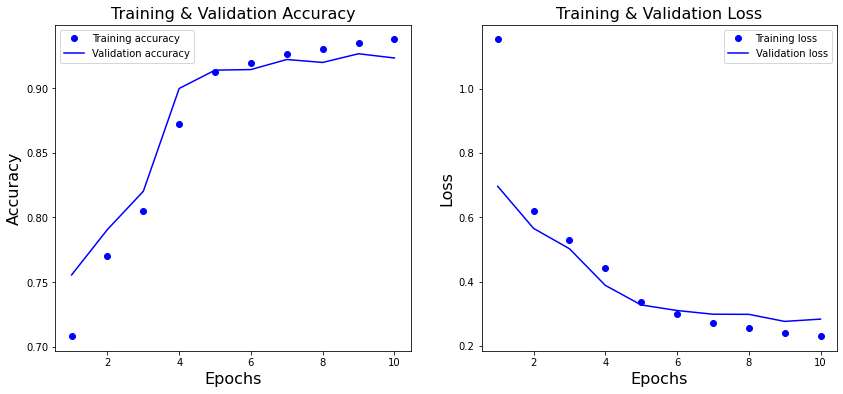

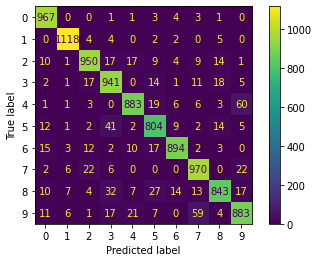

Accuracy
Label 0: 98.67 %
Label 1: 98.50 %
Label 2: 92.05 %
Label 3: 93.17 %
Label 4: 89.92 %
Label 5: 90.13 %
Label 6: 93.32 %
Label 7: 94.36 %
Label 8: 86.55 %
Label 9: 87.51 %
A taxa de aprendizagem atual é 0.003
313/313 [==============================] - 1s 3ms/step - loss: 0.2731 - accuracy: 0.9315
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.99      1135
           2       0.92      0.94      0.93      1032
           3       0.90      0.94      0.92      1010
           4       0.88      0.96      0.92       982
           5       0.91      0.93      0.92       892
           6       0.96      0.94      0.95       958
           7       0.95      0.91      0.93      1028
           8       0.95      0.84      0.90       974
           9       0.90      0.87      0.88      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93  

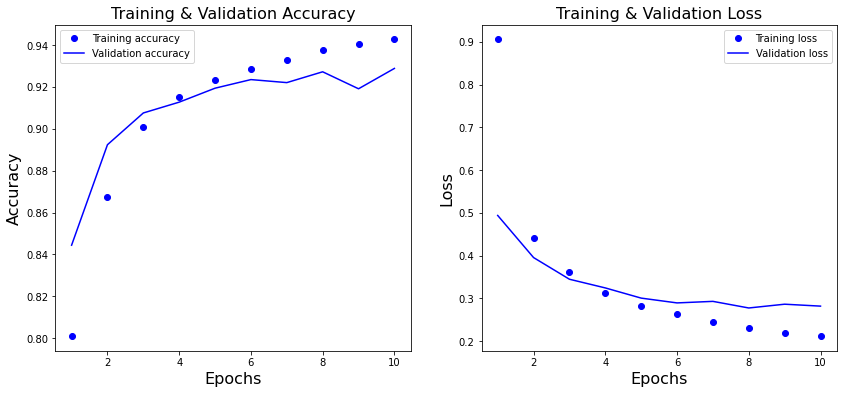

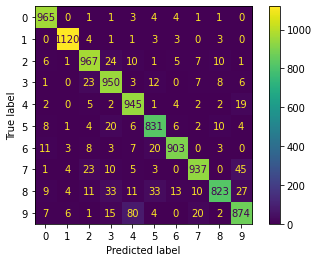

Accuracy
Label 0: 98.47 %
Label 1: 98.68 %
Label 2: 93.70 %
Label 3: 94.06 %
Label 4: 96.23 %
Label 5: 93.16 %
Label 6: 94.26 %
Label 7: 91.15 %
Label 8: 84.50 %
Label 9: 86.62 %
A taxa de aprendizagem atual é 0.004
313/313 [==============================] - 1s 3ms/step - loss: 0.2733 - accuracy: 0.9294
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.99      0.98      1135
           2       0.93      0.89      0.91      1032
           3       0.91      0.93      0.92      1010
           4       0.97      0.86      0.91       982
           5       0.93      0.90      0.91       892
           6       0.96      0.94      0.95       958
           7       0.95      0.94      0.94      1028
           8       0.85      0.93      0.89       974
           9       0.87      0.93      0.90      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93  

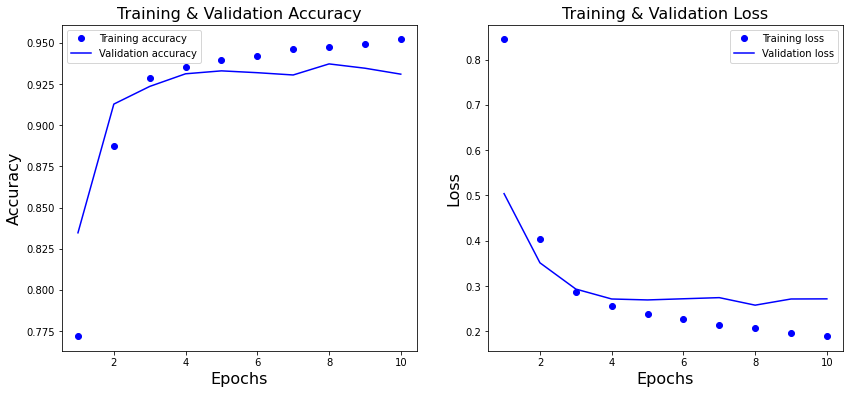

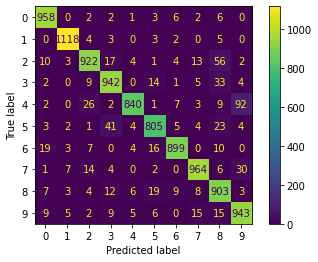

Accuracy
Label 0: 97.76 %
Label 1: 98.50 %
Label 2: 89.34 %
Label 3: 93.27 %
Label 4: 85.54 %
Label 5: 90.25 %
Label 6: 93.84 %
Label 7: 93.77 %
Label 8: 92.71 %
Label 9: 93.46 %
A taxa de aprendizagem atual é 0.005
313/313 [==============================] - 1s 3ms/step - loss: 0.2654 - accuracy: 0.9360
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.91      0.95      0.93      1032
           3       0.90      0.93      0.92      1010
           4       0.93      0.92      0.93       982
           5       0.96      0.86      0.91       892
           6       0.95      0.95      0.95       958
           7       0.95      0.94      0.94      1028
           8       0.90      0.92      0.91       974
           9       0.90      0.91      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.93      0.94  

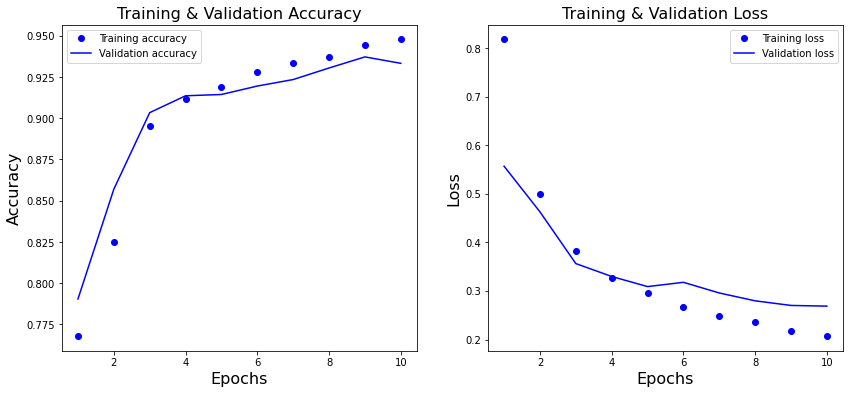

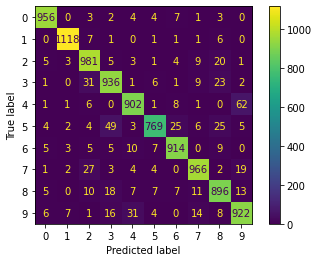

Accuracy
Label 0: 97.55 %
Label 1: 98.50 %
Label 2: 95.06 %
Label 3: 92.67 %
Label 4: 91.85 %
Label 5: 86.21 %
Label 6: 95.41 %
Label 7: 93.97 %
Label 8: 91.99 %
Label 9: 91.38 %
A taxa de aprendizagem atual é 0.006
313/313 [==============================] - 1s 4ms/step - loss: 0.2610 - accuracy: 0.9412
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.98      0.98      1135
           2       0.95      0.91      0.93      1032
           3       0.89      0.94      0.92      1010
           4       0.94      0.93      0.93       982
           5       0.96      0.91      0.93       892
           6       0.96      0.96      0.96       958
           7       0.96      0.93      0.95      1028
           8       0.90      0.94      0.92       974
           9       0.92      0.92      0.92      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94  

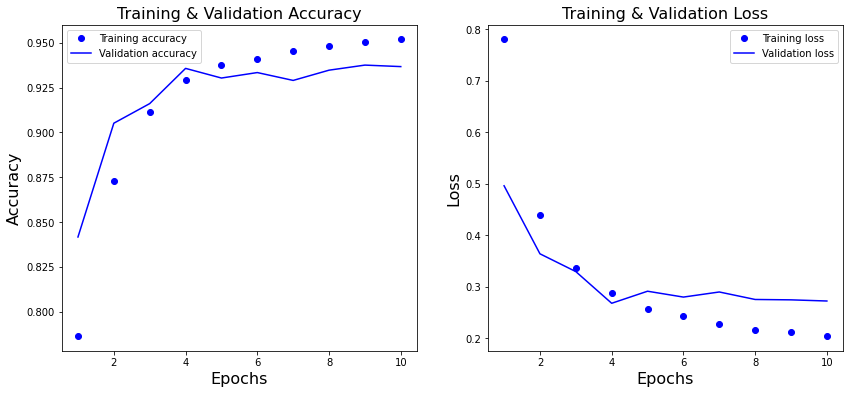

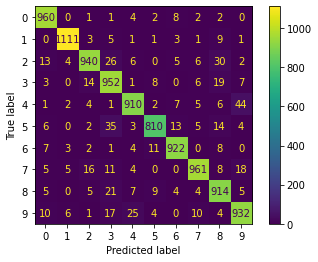

Accuracy
Label 0: 97.96 %
Label 1: 97.89 %
Label 2: 91.09 %
Label 3: 94.26 %
Label 4: 92.67 %
Label 5: 90.81 %
Label 6: 96.24 %
Label 7: 93.48 %
Label 8: 93.84 %
Label 9: 92.37 %
A taxa de aprendizagem atual é 0.007
313/313 [==============================] - 1s 3ms/step - loss: 0.2471 - accuracy: 0.9460
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.96      0.94      1032
           3       0.93      0.93      0.93      1010
           4       0.96      0.92      0.94       982
           5       0.96      0.91      0.94       892
           6       0.98      0.94      0.96       958
           7       0.96      0.95      0.95      1028
           8       0.90      0.93      0.91       974
           9       0.93      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95  

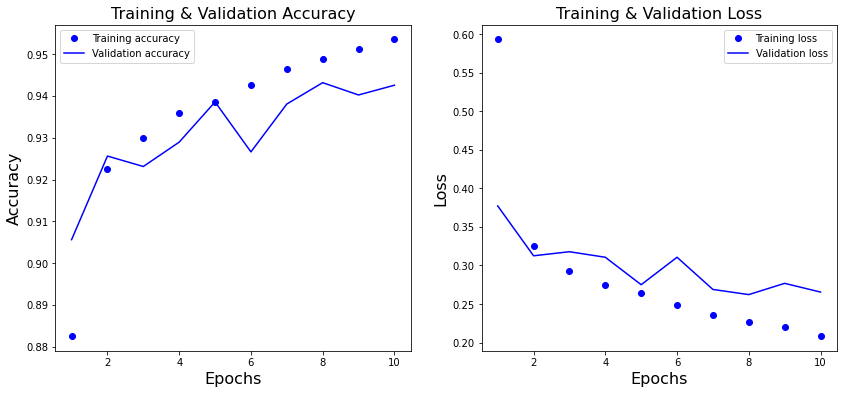

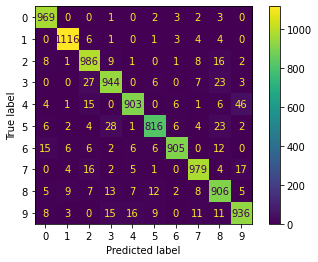

Accuracy
Label 0: 98.88 %
Label 1: 98.33 %
Label 2: 95.54 %
Label 3: 93.47 %
Label 4: 91.96 %
Label 5: 91.48 %
Label 6: 94.47 %
Label 7: 95.23 %
Label 8: 93.02 %
Label 9: 92.77 %
A taxa de aprendizagem atual é 0.008
313/313 [==============================] - 1s 3ms/step - loss: 0.2769 - accuracy: 0.9406
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.94      0.94      0.94      1032
           3       0.91      0.95      0.93      1010
           4       0.98      0.87      0.92       982
           5       0.94      0.91      0.92       892
           6       0.97      0.95      0.96       958
           7       0.96      0.94      0.95      1028
           8       0.94      0.91      0.92       974
           9       0.86      0.96      0.90      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94  

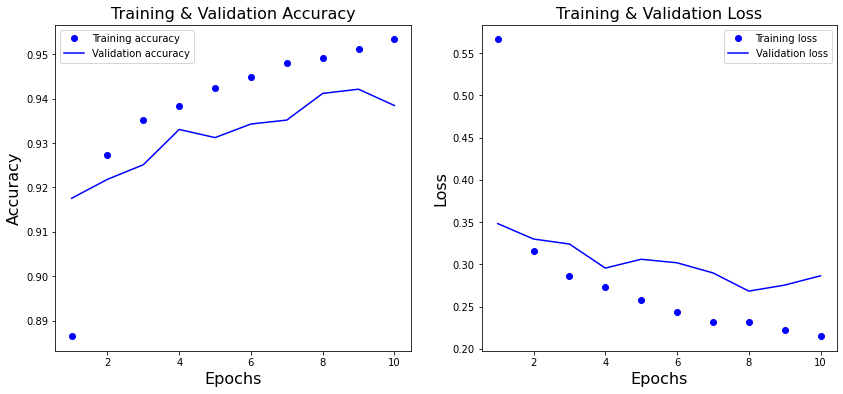

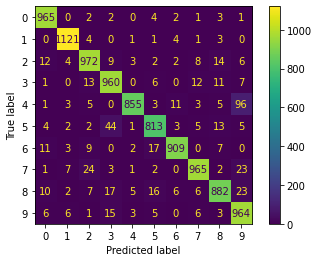

Accuracy
Label 0: 98.47 %
Label 1: 98.77 %
Label 2: 94.19 %
Label 3: 95.05 %
Label 4: 87.07 %
Label 5: 91.14 %
Label 6: 94.89 %
Label 7: 93.87 %
Label 8: 90.55 %
Label 9: 95.54 %
A taxa de aprendizagem atual é 0.009000000000000001
313/313 [==============================] - 1s 4ms/step - loss: 0.2687 - accuracy: 0.9433
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.92      0.93      1032
           3       0.94      0.93      0.93      1010
           4       0.93      0.96      0.95       982
           5       0.92      0.93      0.93       892
           6       0.98      0.92      0.95       958
           7       0.96      0.95      0.96      1028
           8       0.88      0.94      0.91       974
           9       0.95      0.90      0.93      1009

    accuracy                           0.94     10000
   macro avg       0.94      0

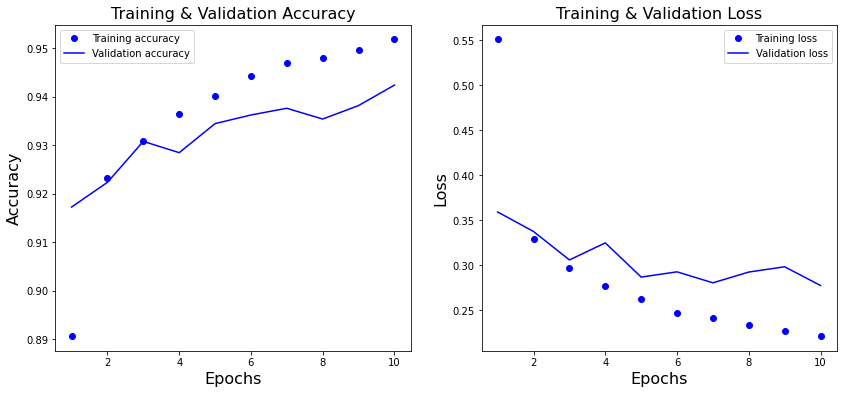

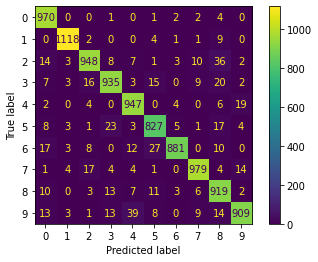

Accuracy
Label 0: 98.98 %
Label 1: 98.50 %
Label 2: 91.86 %
Label 3: 92.57 %
Label 4: 96.44 %
Label 5: 92.71 %
Label 6: 91.96 %
Label 7: 95.23 %
Label 8: 94.35 %
Label 9: 90.09 %


In [ ]:
eval = []
for i in np.arange(0.001, 0.01, 0.001):
  model_MLP_1_lr = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(100, activation = 'softmax'),
     layers.Dense(num_class, activation = 'softmax')                     
  ])
  print("A taxa de aprendizagem atual é " + str(i))
  optimizer = keras.optimizers.Adam(learning_rate=i)
  eval_1_lr, history_1_lr = networkExperiment(model_MLP_1_lr, optimizer = optimizer)
  eval.append(eval_1_lr)
  historyPlot(model_MLP_1_lr, history_1_lr.history, y_test)

#### Resultados

In [ ]:
values = np.arange(0.001, 0.01, 0.001)
for i in range(len(eval)):
  print(("Taxa " + str(values[i]) + " | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval[i][0], percentage1=100*(eval[i][1])))

Taxa 0.001 | Accuracy: 86.47 % | Loss: 0.39
Taxa 0.002 | Accuracy: 92.53 % | Loss: 0.27
Taxa 0.003 | Accuracy: 93.15 % | Loss: 0.27
Taxa 0.004 | Accuracy: 92.94 % | Loss: 0.27
Taxa 0.005 | Accuracy: 93.60 % | Loss: 0.27
Taxa 0.006 | Accuracy: 94.12 % | Loss: 0.26
Taxa 0.007 | Accuracy: 94.60 % | Loss: 0.25
Taxa 0.008 | Accuracy: 94.06 % | Loss: 0.28
Taxa 0.009000000000000001 | Accuracy: 94.33 % | Loss: 0.27


Para valores muito grandes do learning rate, pode haver a divergência do gradient descent na etapa do backpropagation. Por outro lado, com um learning rate muito pequeno, a aprendizagem pode ser lenta o suficiente para atrapalhar o aprendizado nos epochs definidos. Dentre os valores definidos acima, observa-se que 0.007 apresentou maior acurácia e menor loss.

### Função de ativação
#### Relu, Softmax, Tanh, sigmoid

A função de ativação de um nó determina como a soma ponderada da entrada é transformada na saída de um nó da rede. Utilizamos as seguintes funções:



1.   ReLU: Caso o valor seja negativo, retorna $0$, caso contrário, o $x$ é retornado. 
<br>
<img src=https://www.researchgate.net/profile/Muhammad-Farrukh-5/publication/338580890/figure/fig4/AS:847253531009024@1579012391114/Graph-for-Relu-Function.ppm/>

2.   Softmax: Retorna uma lista de probabilidades para cada classe em que todos os valores somam 1. Isso é obtido pelo cálculo do exponencial de cada valor na lista e dividindo pela soma do exponencial dos valores.
<br>
<img src=https://ai-master.gitbooks.io/logistic-regression/content/assets/sigmoid_function.png/ alt = "drawing" height="290" width="370"/>

3.   Tanh: Pega qualquer valor real como entrada e retorna um valor no intervalo $[-1, 1]$. Maior a entrada, mais próximo será de 1 e menor a entrada, mais próximo será de -1.
<br>
<img src=https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-27_at_4.23.22_PM_dcuMBJl.png alt = "drawing" height="290" width="370"/>

4.   Sigmoid: Também chamada de função logística, ela pega um valor real como entrada e retorna valores de saída no intervalo $[0, 1]$. Maior a entrada, mais próximo de 1 e menor a entrada, mais próximo será de 0.
<br>
<img src=https://ai-master.gitbooks.io/logistic-regression/content/assets/sigmoid_function.png alt = "drawing" height="290" widht="370"/>


In [ ]:
model_MLP_1_fa = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(100, activation = 'softmax'), 
     layers.Dense(num_class, activation = 'softmax')                     
])

313/313 [==============================] - 1s 3ms/step - loss: 0.3161 - accuracy: 0.9163
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.98      0.99      0.98      1135
           2       0.91      0.92      0.92      1032
           3       0.92      0.91      0.91      1010
           4       0.90      0.90      0.90       982
           5       0.92      0.85      0.88       892
           6       0.93      0.96      0.94       958
           7       0.87      0.93      0.90      1028
           8       0.89      0.90      0.90       974
           9       0.88      0.80      0.84      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.92      0.92      0.92     10000



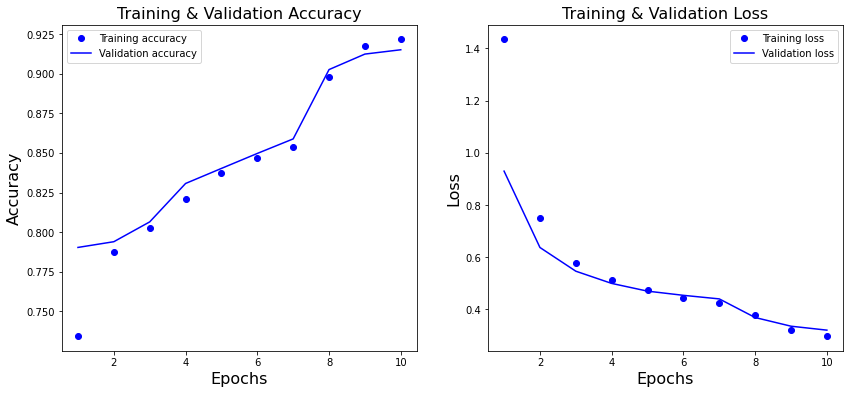

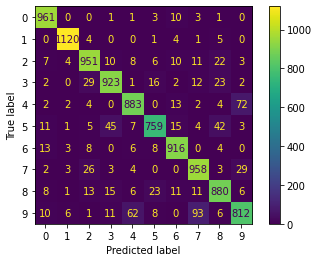

Accuracy
Label 0: 98.06 %
Label 1: 98.68 %
Label 2: 92.15 %
Label 3: 91.39 %
Label 4: 89.92 %
Label 5: 85.09 %
Label 6: 95.62 %
Label 7: 93.19 %
Label 8: 90.35 %
Label 9: 80.48 %


In [ ]:
eval_1, history_1 = networkExperiment(model_MLP_1_fa)
historyPlot(model_MLP_1_fa, history_1.history, y_test)

In [ ]:
model_MLP_2_fa = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(100, activation = 'relu'), 
     layers.Dense(num_class, activation = 'softmax')                     
])

313/313 [==============================] - 1s 3ms/step - loss: 0.0872 - accuracy: 0.9762
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.97      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.97      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



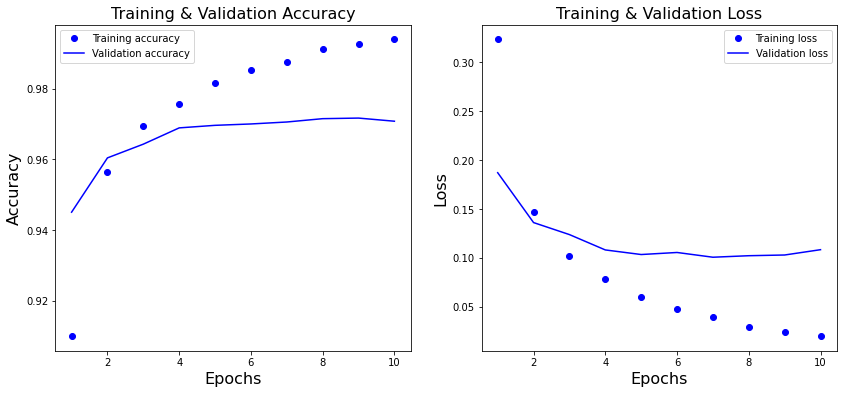

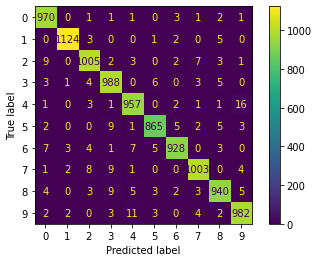

Accuracy
Label 0: 98.98 %
Label 1: 99.03 %
Label 2: 97.38 %
Label 3: 97.82 %
Label 4: 97.45 %
Label 5: 96.97 %
Label 6: 96.87 %
Label 7: 97.57 %
Label 8: 96.51 %
Label 9: 97.32 %


In [ ]:
eval_2, history_2 = networkExperiment(model_MLP_2_fa)
historyPlot(model_MLP_2_fa, history_2.history, y_test)

In [ ]:
model_MLP_3_fa = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(100, activation = 'tanh'), 
     layers.Dense(num_class, activation = 'softmax')                     
])

313/313 [==============================] - 1s 3ms/step - loss: 0.0912 - accuracy: 0.9738
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.95      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



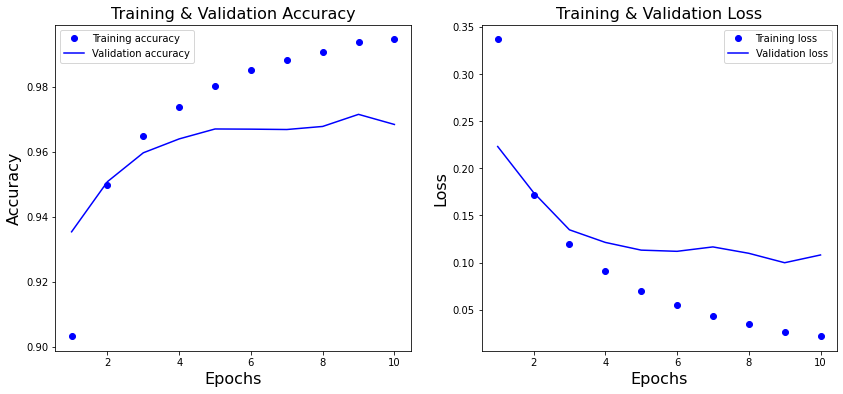

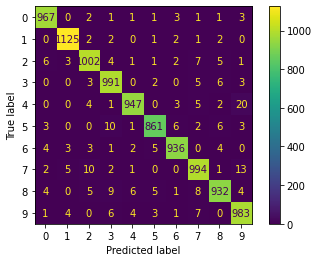

Accuracy
Label 0: 98.67 %
Label 1: 99.12 %
Label 2: 97.09 %
Label 3: 98.12 %
Label 4: 96.44 %
Label 5: 96.52 %
Label 6: 97.70 %
Label 7: 96.69 %
Label 8: 95.69 %
Label 9: 97.42 %


In [ ]:
eval_3, history_3 = networkExperiment(model_MLP_3_fa)
historyPlot(model_MLP_3_fa, history_3.history, y_test)

In [ ]:
model_MLP_4_fa = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),
     layers.Dense(100, activation = 'sigmoid'), 
     layers.Dense(num_class, activation = 'softmax')                     
])

313/313 [==============================] - 1s 3ms/step - loss: 0.0930 - accuracy: 0.9713
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.95      0.98      0.96      1010
           4       0.98      0.96      0.97       982
           5       0.98      0.95      0.96       892
           6       0.97      0.97      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.96      0.96       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



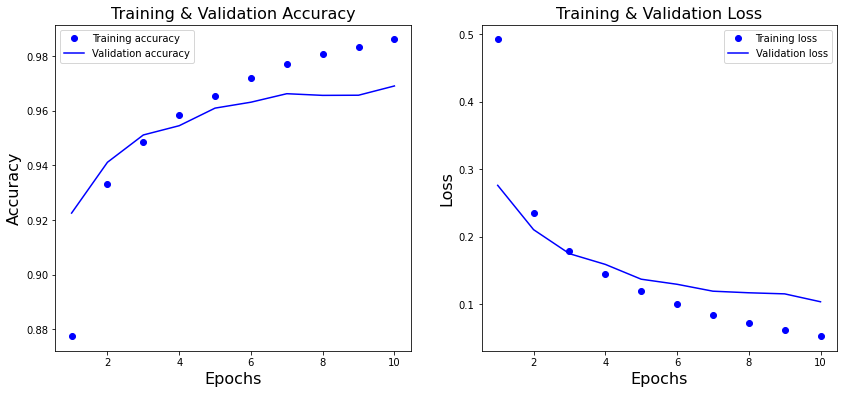

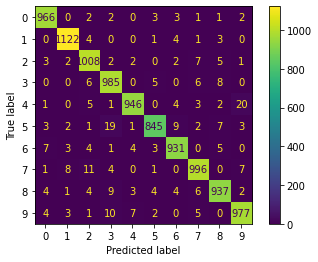

Accuracy
Label 0: 98.57 %
Label 1: 98.85 %
Label 2: 97.67 %
Label 3: 97.52 %
Label 4: 96.33 %
Label 5: 94.73 %
Label 6: 97.18 %
Label 7: 96.89 %
Label 8: 96.20 %
Label 9: 96.83 %


In [ ]:
eval_4, history_4 = networkExperiment(model_MLP_4_fa)
historyPlot(model_MLP_4_fa, history_4.history, y_test)

#### Resultados

In [ ]:
print(("Função de Ativação Softmax | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_1[0], percentage1=100*(eval_1[1])))
print(("Função de Ativação ReLU | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_2[0], percentage1=100*(eval_2[1])))
print(("Função de Ativação Tanh | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_3[0], percentage1=100*(eval_3[1])))
print(("Função de Ativação Sigmoid | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_4[0], percentage1=100*(eval_4[1])))

Função de Ativação Softmax | Accuracy: 91.63 % | Loss: 0.32
Função de Ativação ReLU | Accuracy: 97.62 % | Loss: 0.09
Função de Ativação Tanh | Accuracy: 97.38 % | Loss: 0.09
Função de Ativação Sigmoid | Accuracy: 97.13 % | Loss: 0.09


Com base nos resultados dos testes, temos que as melhores performances foram com as funções de ativação ReLU e tanh. A ReLU é ótima para ser usada em camadas intermediárias em comparação às outras, pois por ser linear, o cálculo da sua derivada é mais fácil, tornando a etapa de backpropagation mais rápida que as outras funções de ativação.

A tanh também teve resultados satisfatórios, contudo, pelos motivos acima, a relu ainda é mais recomendada.

Além disso, o uso e funções lineares evita o problema de "vanishing gradient", que ocorre quando a derivada de uma função em um certo ponto é muito pequena e evita que ocorra a mudança significativa de pesos na etapa de backpropagation. 

### Algoritmo de Aprendizagem
#### Adam, RMSProp, SGD
Gradientes podem explodir ou esvanecer, a depender do learning rate ou do algoritmo de aprendizagem. O "vanishing gradient" é um dos problemas que podem ocorrer na atualização dos valores dos pesos, onde o gradiente tende a zero e a aprendizagem é lenta ou inexistente.

Nesse experimento, iremos variar os algoritmos de otimização da aprendizagem na etapa de backpropagation.

Iremos explorar o Adam, RMSProp e Gradiente Descendente Estocástico(SGD).



#### Adam




A otimização de Adam é um método de gradiente descendente estocástico que é baseado na estimativa adaptativa dos momentos de primeira e segunda ordem.




In [ ]:
model_MLP_1_aa = keras.Sequential([
     keras.Input(shape=input_shape), 
     layers.Flatten(),                     
     layers.Dense(num_class, activation = 'softmax')                     
])

313/313 [==============================] - 1s 4ms/step - loss: 0.2702 - accuracy: 0.9247
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.88      0.91      1032
           3       0.91      0.91      0.91      1010
           4       0.93      0.94      0.93       982
           5       0.89      0.89      0.89       892
           6       0.93      0.96      0.95       958
           7       0.92      0.93      0.92      1028
           8       0.87      0.89      0.88       974
           9       0.93      0.89      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



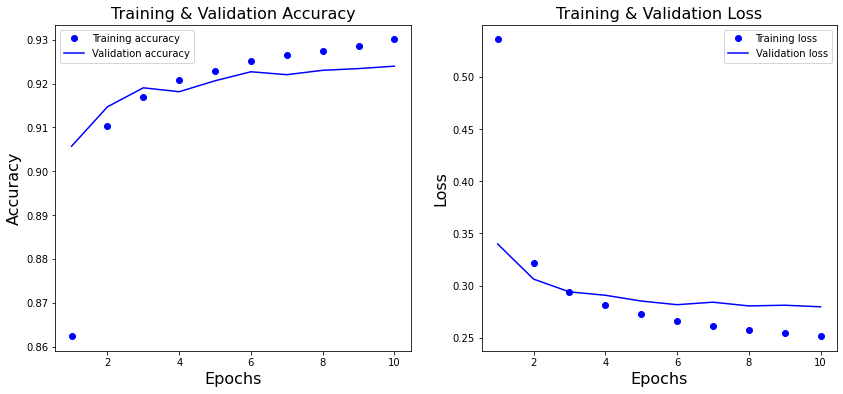

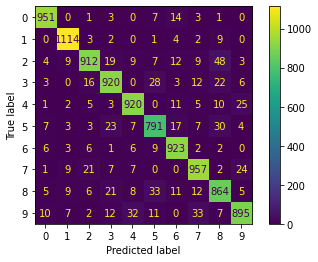

Accuracy
Label 0: 97.04 %
Label 1: 98.15 %
Label 2: 88.37 %
Label 3: 91.09 %
Label 4: 93.69 %
Label 5: 88.68 %
Label 6: 96.35 %
Label 7: 93.09 %
Label 8: 88.71 %
Label 9: 88.70 %


In [ ]:
eval_1, history_1 = networkExperiment(model_MLP_1_aa, optimizer = 'adam')
historyPlot(model_MLP_1_aa, history_1.history, y_test)

#### RMSProp
A essência do RMSProp é de manter uma média móvel do quadrado dos gradientes e dividir o gradiente pela raiz desta média.

313/313 [==============================] - 1s 4ms/step - loss: 0.2952 - accuracy: 0.9269
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.97      0.98      0.97      1135
           2       0.93      0.90      0.91      1032
           3       0.92      0.90      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.87      0.89       892
           6       0.94      0.95      0.95       958
           7       0.94      0.92      0.93      1028
           8       0.88      0.90      0.89       974
           9       0.90      0.92      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



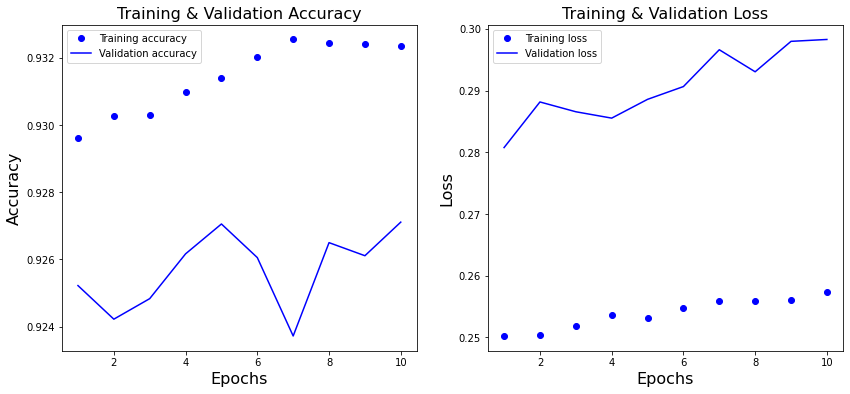

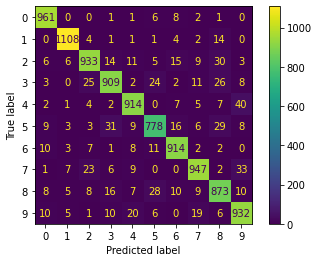

Accuracy
Label 0: 98.06 %
Label 1: 97.62 %
Label 2: 90.41 %
Label 3: 90.00 %
Label 4: 93.08 %
Label 5: 87.22 %
Label 6: 95.41 %
Label 7: 92.12 %
Label 8: 89.63 %
Label 9: 92.37 %


In [ ]:
eval_2, history_2 = networkExperiment(model_MLP_1_aa, optimizer = 'RMSProp')
historyPlot(model_MLP_1_aa, history_2.history, y_test)

#### SGD
O SGD utiliza registros únicos para atualizar os parâmetros, mas ele é lento em convergir pois é necessário fazer a propagação para frente e para trás para cada registro e o caminho para chegar ao mínimo local se torna muito ruidoso

313/313 [==============================] - 1s 4ms/step - loss: 0.2890 - accuracy: 0.9277
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.97      0.98      0.98      1135
           2       0.92      0.91      0.91      1032
           3       0.91      0.90      0.91      1010
           4       0.94      0.93      0.93       982
           5       0.91      0.87      0.89       892
           6       0.94      0.95      0.95       958
           7       0.93      0.93      0.93      1028
           8       0.88      0.90      0.89       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



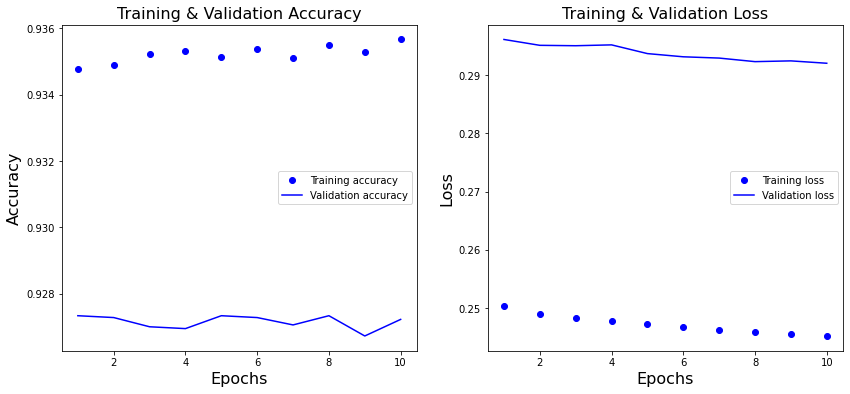

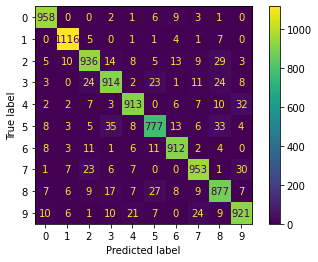

Accuracy
Label 0: 97.76 %
Label 1: 98.33 %
Label 2: 90.70 %
Label 3: 90.50 %
Label 4: 92.97 %
Label 5: 87.11 %
Label 6: 95.20 %
Label 7: 92.70 %
Label 8: 90.04 %
Label 9: 91.28 %


In [ ]:
eval_3, history_3 = networkExperiment(model_MLP_1_aa, optimizer = 'SGD')
historyPlot(model_MLP_1_aa, history_3.history, y_test)

#### Resultados

In [ ]:
print(("Algoritmo Adam | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_1[0], percentage1=100*(eval_1[1])))
print(("Algoritmo RMSProp | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_2[0], percentage1=100*(eval_2[1])))
print(("Algoritmo SGD | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_3[0], percentage1=100*(eval_3[1])))

Algoritmo Adam | Accuracy: 92.47 % | Loss: 0.27
Algoritmo RMSProp | Accuracy: 92.69 % | Loss: 0.30
Algoritmo SGD | Accuracy: 92.77 % | Loss: 0.29



Dos algoritmos de otimização, o Adam se saiu melhor otimizando o modelo, pois incorpora e estende a heurística do RMSProp, que por sua vez estende o SGD.


### Dropout
#### $0.2, 0.3, 0.4, 0.5, 0.6$ ou $0.7$

A técnica de dropout consiste no descarte de nós aleatórios entre camadas do modelo. Essa técnica é utilizada para evitar o overfitting dos dados, quando o modelo não é preciso com dados não vistos. Optamos por testar a acurácia e loss para valores entre $[0.2, 0.7]$ com passo $0.1$.

O dropout atual é: 0.2
313/313 [==============================] - 1s 3ms/step - loss: 0.2702 - accuracy: 0.9256
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.99      0.97      1135
           2       0.91      0.90      0.90      1032
           3       0.92      0.90      0.91      1010
           4       0.93      0.93      0.93       982
           5       0.91      0.87      0.89       892
           6       0.94      0.95      0.94       958
           7       0.94      0.92      0.93      1028
           8       0.88      0.90      0.89       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



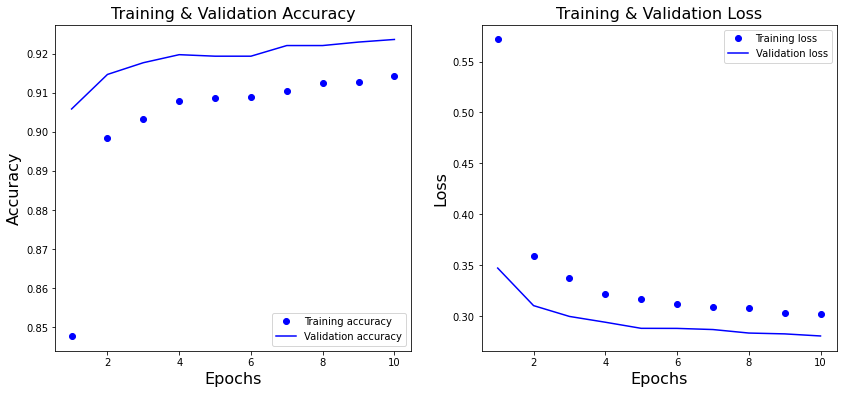

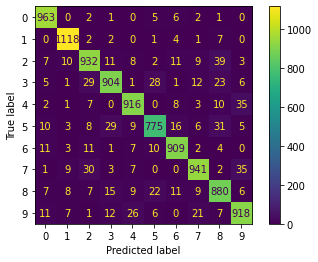

Accuracy
Label 0: 98.27 %
Label 1: 98.50 %
Label 2: 90.31 %
Label 3: 89.50 %
Label 4: 93.28 %
Label 5: 86.88 %
Label 6: 94.89 %
Label 7: 91.54 %
Label 8: 90.35 %
Label 9: 90.98 %
O dropout atual é: 0.30000000000000004
313/313 [==============================] - 1s 3ms/step - loss: 0.2750 - accuracy: 0.9264
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.98      0.98      0.98      1135
           2       0.92      0.90      0.91      1032
           3       0.92      0.90      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.92      0.87      0.89       892
           6       0.93      0.96      0.95       958
           7       0.92      0.93      0.93      1028
           8       0.87      0.91      0.89       974
           9       0.92      0.89      0.91      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93

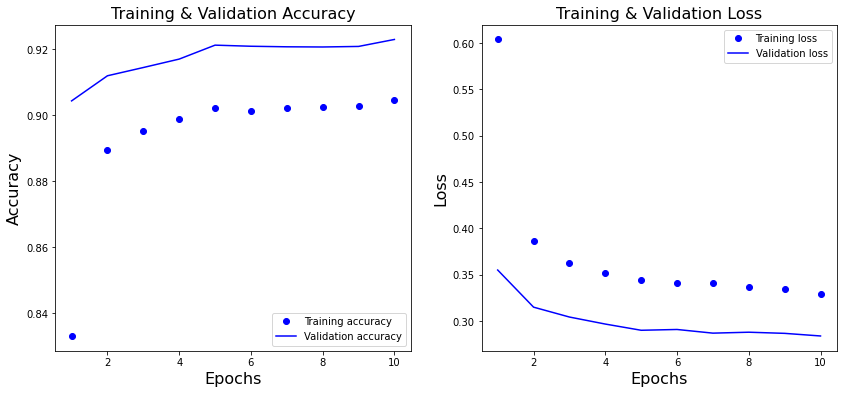

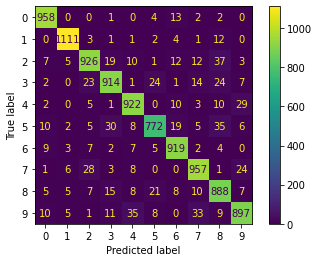

Accuracy
Label 0: 97.76 %
Label 1: 97.89 %
Label 2: 89.73 %
Label 3: 90.50 %
Label 4: 93.89 %
Label 5: 86.55 %
Label 6: 95.93 %
Label 7: 93.09 %
Label 8: 91.17 %
Label 9: 88.90 %
O dropout atual é: 0.4000000000000001
313/313 [==============================] - 1s 3ms/step - loss: 0.2827 - accuracy: 0.9225
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.87      0.90      1032
           3       0.91      0.90      0.91      1010
           4       0.91      0.94      0.92       982
           5       0.91      0.88      0.89       892
           6       0.93      0.96      0.94       958
           7       0.95      0.90      0.93      1028
           8       0.87      0.90      0.88       974
           9       0.90      0.91      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92 

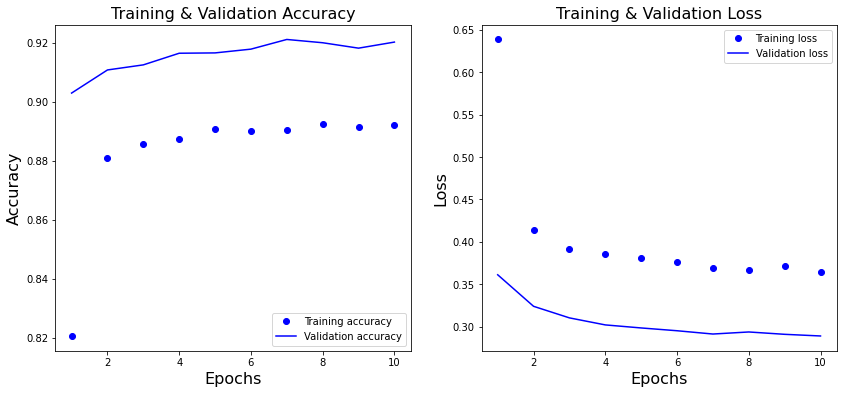

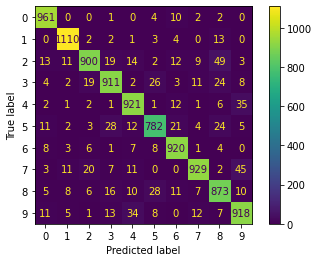

Accuracy
Label 0: 98.06 %
Label 1: 97.80 %
Label 2: 87.21 %
Label 3: 90.20 %
Label 4: 93.79 %
Label 5: 87.67 %
Label 6: 96.03 %
Label 7: 90.37 %
Label 8: 89.63 %
Label 9: 90.98 %
O dropout atual é: 0.5000000000000001
313/313 [==============================] - 1s 4ms/step - loss: 0.2876 - accuracy: 0.9210
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.98      0.97      1135
           2       0.93      0.89      0.91      1032
           3       0.92      0.90      0.91      1010
           4       0.93      0.92      0.92       982
           5       0.91      0.87      0.89       892
           6       0.93      0.95      0.94       958
           7       0.93      0.91      0.92      1028
           8       0.86      0.90      0.88       974
           9       0.88      0.90      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92 

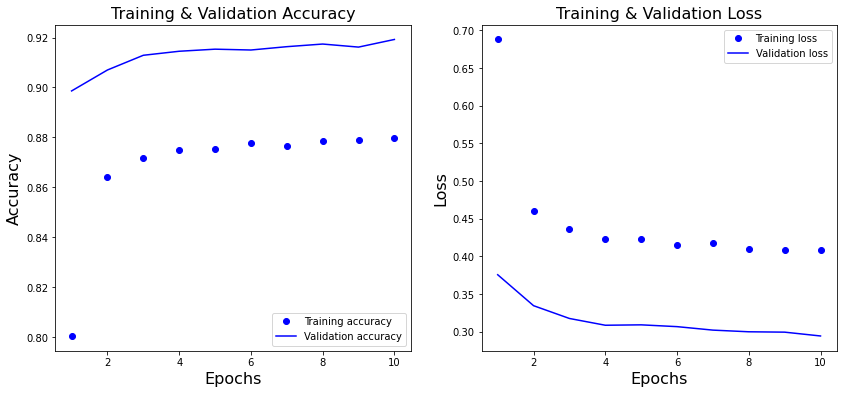

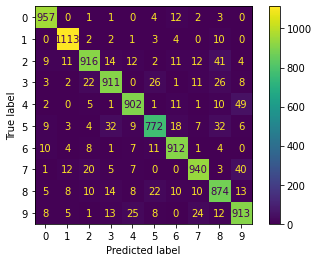

Accuracy
Label 0: 97.65 %
Label 1: 98.06 %
Label 2: 88.76 %
Label 3: 90.20 %
Label 4: 91.85 %
Label 5: 86.55 %
Label 6: 95.20 %
Label 7: 91.44 %
Label 8: 89.73 %
Label 9: 90.49 %
O dropout atual é: 0.6000000000000001
313/313 [==============================] - 1s 4ms/step - loss: 0.3053 - accuracy: 0.9167
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.95      0.98      0.97      1135
           2       0.93      0.88      0.90      1032
           3       0.90      0.91      0.90      1010
           4       0.92      0.92      0.92       982
           5       0.93      0.82      0.87       892
           6       0.92      0.96      0.94       958
           7       0.94      0.90      0.92      1028
           8       0.85      0.90      0.88       974
           9       0.88      0.91      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92 

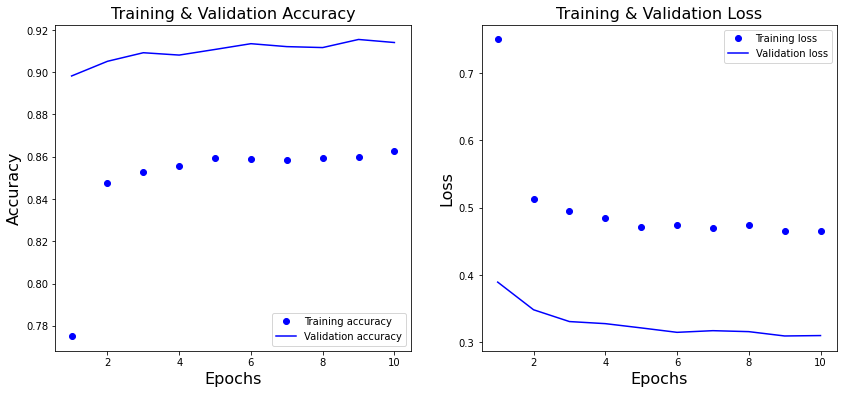

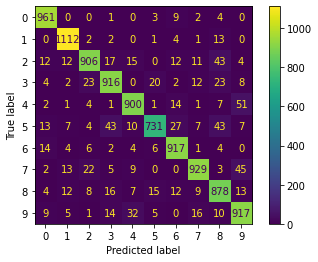

Accuracy
Label 0: 98.06 %
Label 1: 97.97 %
Label 2: 87.79 %
Label 3: 90.69 %
Label 4: 91.65 %
Label 5: 81.95 %
Label 6: 95.72 %
Label 7: 90.37 %
Label 8: 90.14 %
Label 9: 90.88 %
O dropout atual é: 0.7000000000000002
313/313 [==============================] - 1s 4ms/step - loss: 0.3330 - accuracy: 0.9106
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       980
           1       0.95      0.97      0.96      1135
           2       0.94      0.86      0.90      1032
           3       0.88      0.91      0.90      1010
           4       0.93      0.89      0.91       982
           5       0.91      0.82      0.86       892
           6       0.93      0.95      0.94       958
           7       0.95      0.89      0.92      1028
           8       0.84      0.89      0.86       974
           9       0.85      0.92      0.88      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91 

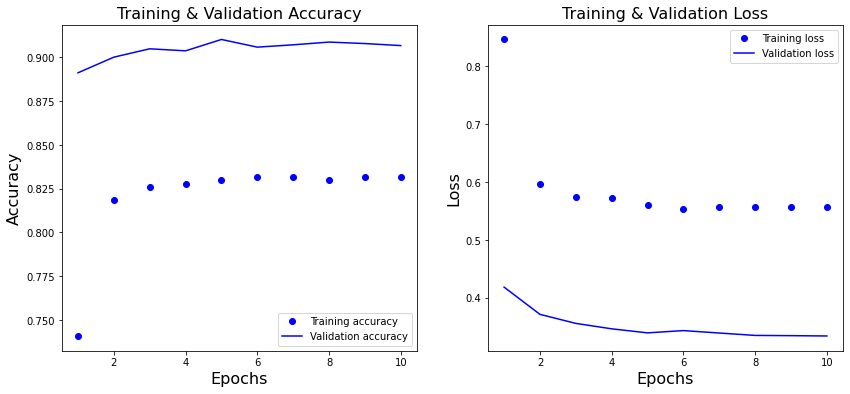

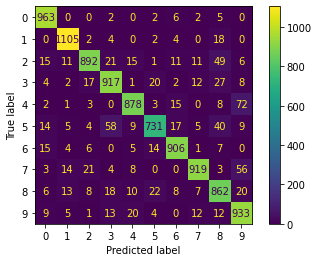

Accuracy
Label 0: 98.27 %
Label 1: 97.36 %
Label 2: 86.43 %
Label 3: 90.79 %
Label 4: 89.41 %
Label 5: 81.95 %
Label 6: 94.57 %
Label 7: 89.40 %
Label 8: 88.50 %
Label 9: 92.47 %
O dropout atual é: 0.8000000000000003
313/313 [==============================] - 1s 4ms/step - loss: 0.3749 - accuracy: 0.9011
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       980
           1       0.93      0.97      0.95      1135
           2       0.94      0.84      0.88      1032
           3       0.86      0.91      0.88      1010
           4       0.92      0.88      0.90       982
           5       0.92      0.78      0.85       892
           6       0.90      0.95      0.92       958
           7       0.94      0.89      0.91      1028
           8       0.83      0.88      0.86       974
           9       0.84      0.92      0.88      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90 

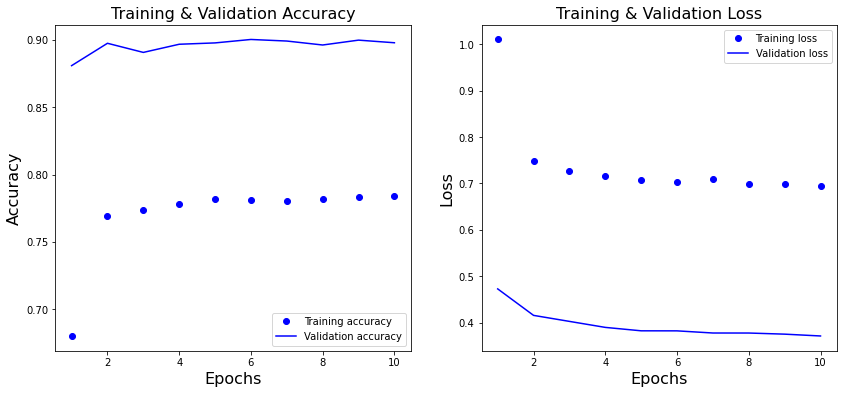

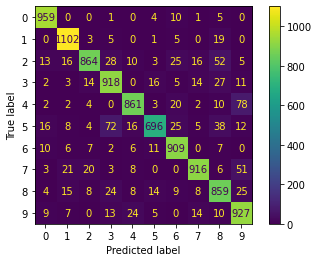

Accuracy
Label 0: 97.86 %
Label 1: 97.09 %
Label 2: 83.72 %
Label 3: 90.89 %
Label 4: 87.68 %
Label 5: 78.03 %
Label 6: 94.89 %
Label 7: 89.11 %
Label 8: 88.19 %
Label 9: 91.87 %


In [ ]:
eval = []
for i in np.arange(0.2, 0.8, 0.1):
  print('O dropout atual é: ' + str(i))
  model_MLP_1_d = keras.Sequential([
      keras.Input(shape=input_shape), 
      layers.Flatten(), 
      layers.Dropout(i),                    
      layers.Dense(num_class, activation = 'softmax')                     
  ])
  eval_1, history_1 = networkExperiment(model_MLP_1_d)
  historyPlot(model_MLP_1_d, history_1.history, y_test)
  eval.append(eval_1)

#### Resultados

In [ ]:
values = np.arange(0.2, 0.8, 0.1)
for i in range(len(eval)):
  print(("Dropout " + str(values[i]) + " | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval[i][0], percentage1=100*(eval[i][1])))

Dropout 0.2 | Accuracy: 92.56 % | Loss: 0.27
Dropout 0.30000000000000004 | Accuracy: 92.64 % | Loss: 0.27
Dropout 0.4000000000000001 | Accuracy: 92.25 % | Loss: 0.28
Dropout 0.5000000000000001 | Accuracy: 92.10 % | Loss: 0.29
Dropout 0.6000000000000001 | Accuracy: 91.67 % | Loss: 0.31
Dropout 0.7000000000000002 | Accuracy: 91.06 % | Loss: 0.33
Dropout 0.8000000000000003 | Accuracy: 90.11 % | Loss: 0.37



Podemos ver que nos experimentos, o dropout de 20% nos deu bons resultados, a partir de 30%, tivemos um aumento no valor da função loss e uma diminuição nas métricas de precisão e recall, sendo 0.7 de dropout a pior performance.
Além disso, com o aumento do dropout, vemos no gráfico que a linha dos valores da etapa de treinamento vai se afastando da linha do valores da etapa de validação, que pode indicar um underfit com o aumento da taxa de dropout.

### Análise Final MLP

Agora que todos os experimentos foram realizados, iremos reunir os melhores valores dos parâmetros em um único modelo e observar sua performance. Os melhores parâmetros foram:

*     Tamanho da rede: 3 camadas
*     Taxa de aprendizagem: 0.007
*     Função de ativação: Relu
*     Algoritmo de aprendizagem: Adam
*     Dropout: 20%

313/313 [==============================] - 1s 3ms/step - loss: 0.1339 - accuracy: 0.9684
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.98      0.95      0.96       892
           6       0.98      0.96      0.97       958
           7       0.98      0.97      0.97      1028
           8       0.95      0.96      0.95       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



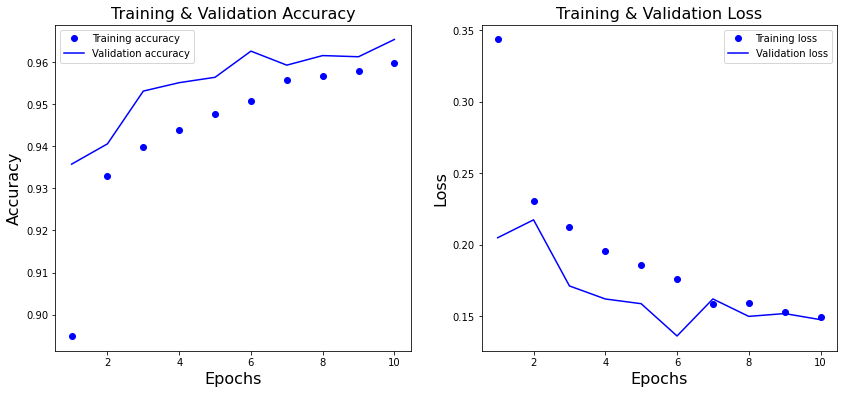

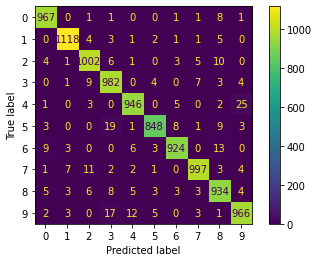

Accuracy
Label 0: 98.67 %
Label 1: 98.50 %
Label 2: 97.09 %
Label 3: 97.23 %
Label 4: 96.33 %
Label 5: 95.07 %
Label 6: 96.45 %
Label 7: 96.98 %
Label 8: 95.89 %
Label 9: 95.74 %


In [ ]:
best_model_MLP = keras.Sequential([
      keras.Input(shape=input_shape), 
      layers.Flatten(), 
      layers.Dense(100, activation = 'relu'),
      layers.Dropout(0.2),          
      layers.Dense(100, activation = 'relu'),          
      layers.Dense(num_class, activation = 'softmax')                     
])

optimizer = keras.optimizers.Adam(learning_rate=0.007)
 
best_eval_MLP, history_1 = networkExperiment(best_model_MLP, optimizer = optimizer)
historyPlot(best_model_MLP, history_1.history, y_test)

In [ ]:
print(("Best Model | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=best_eval_MLP[0], percentage1=100*(best_eval_MLP[1])))

Best Model | Accuracy: 96.84 % | Loss: 0.13


## Estudo CNN




### Tamanho da rede 
#### $1, 2$ ou $3$ camadas convolucionais

Primeiramente iremos analisar a influência do tamanho da rede na acurácia e no loss do modelo. Vamos considerar a camada de convolução de $32$ filtros $(3, 3)$ + camada de max pooling $(2, 2)$ como uma única camada. Todos os modelos terão uma camada densa de saída de $10$ unidades.

Criamos $3$ modelos:
 

1.   $1$ camada
2.   $2$ camadas
3.   $3$ camadas


In [ ]:
model_CNN_1 = keras.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
      layers.MaxPool2D((2, 2)),
      layers.Flatten(),
      layers.Dense(num_class, activation = 'softmax')
])

313/313 [==============================] - 1s 4ms/step - loss: 0.0703 - accuracy: 0.9825
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



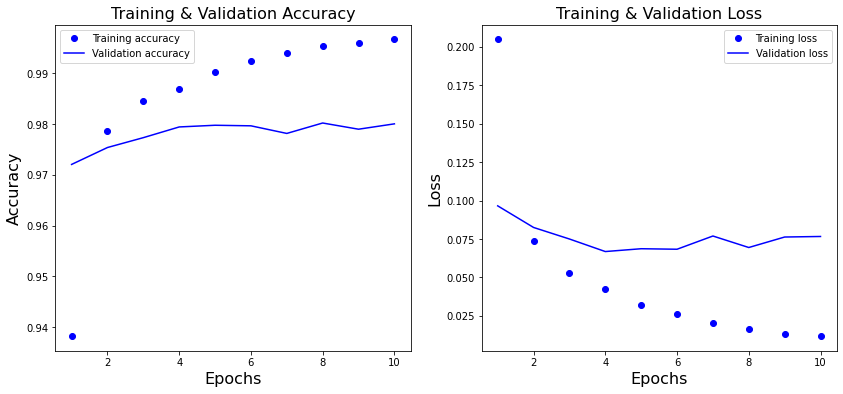

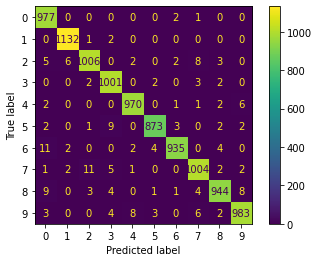

Accuracy
Label 0: 99.69 %
Label 1: 99.74 %
Label 2: 97.48 %
Label 3: 99.11 %
Label 4: 98.78 %
Label 5: 97.87 %
Label 6: 97.60 %
Label 7: 97.67 %
Label 8: 96.92 %
Label 9: 97.42 %


In [ ]:
eval_1, history_1 = networkExperiment(model_CNN_1)
historyPlot(model_CNN_1, history_1.history, y_test)

In [ ]:
model_CNN_2 = keras.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
      layers.MaxPool2D((2, 2)),
      layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'),
      layers.MaxPool2D((2, 2)),
      layers.Flatten(),
      layers.Dense(num_class, activation = 'softmax')
])

313/313 [==============================] - 1s 4ms/step - loss: 0.0448 - accuracy: 0.9864
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.98      0.99      0.98       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.97      0.99      0.98       974
           9       0.98      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



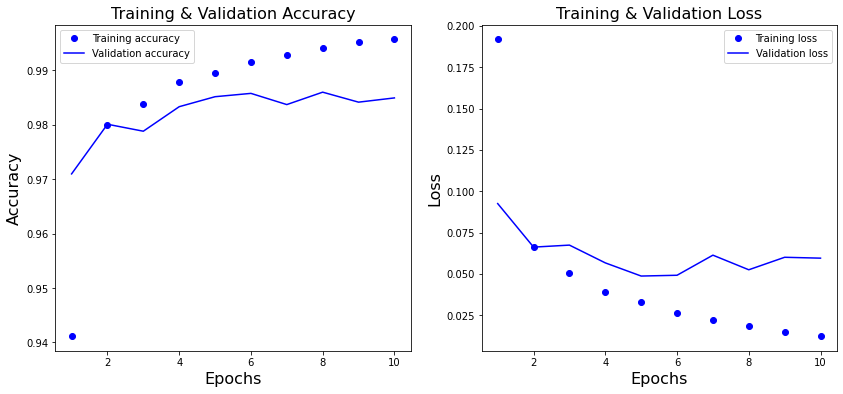

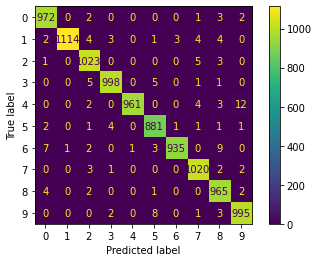

Accuracy
Label 0: 99.18 %
Label 1: 98.15 %
Label 2: 99.13 %
Label 3: 98.81 %
Label 4: 97.86 %
Label 5: 98.77 %
Label 6: 97.60 %
Label 7: 99.22 %
Label 8: 99.08 %
Label 9: 98.61 %


In [ ]:
eval_2, history_2 = networkExperiment(model_CNN_2)
historyPlot(model_CNN_2, history_2.history, y_test)

In [ ]:
model_CNN_3 = keras.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
      layers.MaxPool2D((2, 2)),
      layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'),
      layers.MaxPool2D((2, 2)),
      layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'),
      layers.MaxPool2D((2, 2)),
      layers.Flatten(),
      layers.Dense(num_class, activation = 'softmax')
])

313/313 [==============================] - 1s 4ms/step - loss: 0.0631 - accuracy: 0.9832
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.97      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



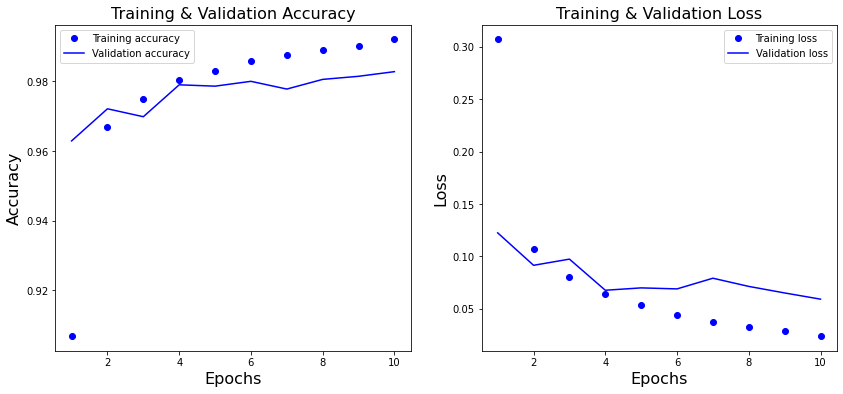

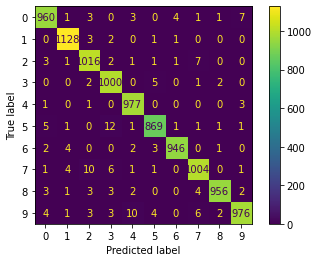

Accuracy
Label 0: 97.96 %
Label 1: 99.38 %
Label 2: 98.45 %
Label 3: 99.01 %
Label 4: 99.49 %
Label 5: 97.42 %
Label 6: 98.75 %
Label 7: 97.67 %
Label 8: 98.15 %
Label 9: 96.73 %


In [ ]:
eval_3, history_3 = networkExperiment(model_CNN_3)
historyPlot(model_CNN_3, history_3.history, y_test)

#### Resultados

In [ ]:
print(("Tamanho 1 | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_1[0], percentage1=100*(eval_1[1])))
print(("Tamanho 2 | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_2[0], percentage1=100*(eval_2[1])))
print(("Tamanho 3 | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval_3[0], percentage1=100*(eval_3[1])))

Tamanho 1 | Accuracy: 98.25 % | Loss: 0.07
Tamanho 2 | Accuracy: 98.64 % | Loss: 0.04
Tamanho 3 | Accuracy: 98.32 % | Loss: 0.06



Com base nos resultados obtidos, temos que, em geral, a abordagem por redes convolucionais é superior no problema de reconhecimento e dígitos.  A rede de 2 camadas teve os melhores resultados, com uma média de precisão e recall de 0.99 com uma acurácia de quase 99% e o menor valor para a função loss.

### Dropout 
#### $0.2, 0.3, 0.4, 0.5, 0.6$ ou $0.7$

A técnica de dropout consiste no descarte de nós aleatórios entre camadas do modelo. Essa técnica é utilizada para evitar o overfitting, quando o modelo não é preciso com dados não vistos. Optamos por testar a acurácia e loss para valores entre $[0.2, 0.7]$ com passo $0.1$.

313/313 [==============================] - 1s 4ms/step - loss: 0.0594 - accuracy: 0.9830
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



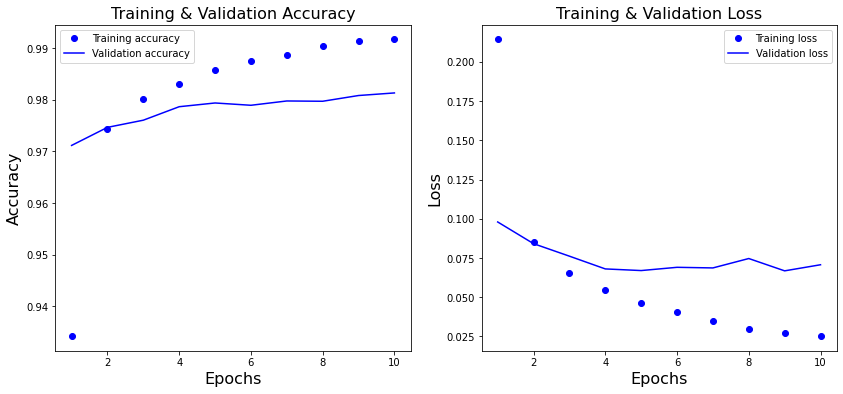

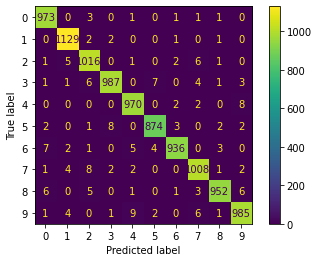

Accuracy
Label 0: 99.29 %
Label 1: 99.47 %
Label 2: 98.45 %
Label 3: 97.72 %
Label 4: 98.78 %
Label 5: 97.98 %
Label 6: 97.70 %
Label 7: 98.05 %
Label 8: 97.74 %
Label 9: 97.62 %
313/313 [==============================] - 1s 4ms/step - loss: 0.0523 - accuracy: 0.9844
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98     

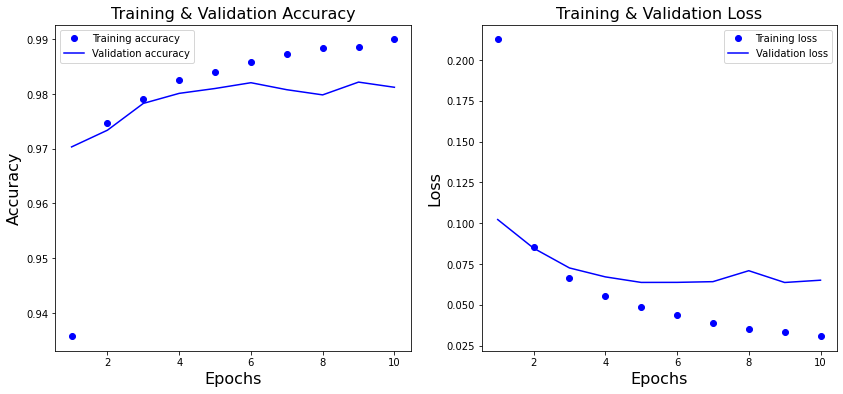

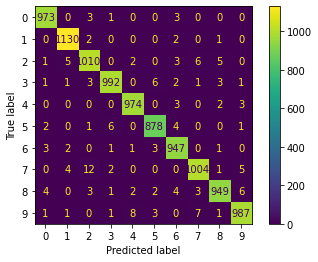

Accuracy
Label 0: 99.29 %
Label 1: 99.56 %
Label 2: 97.87 %
Label 3: 98.22 %
Label 4: 99.19 %
Label 5: 98.43 %
Label 6: 98.85 %
Label 7: 97.67 %
Label 8: 97.43 %
Label 9: 97.82 %
313/313 [==============================] - 1s 4ms/step - loss: 0.0522 - accuracy: 0.9835
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.97      0.98      0.98      1028
           8       0.96      0.99      0.97       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98     

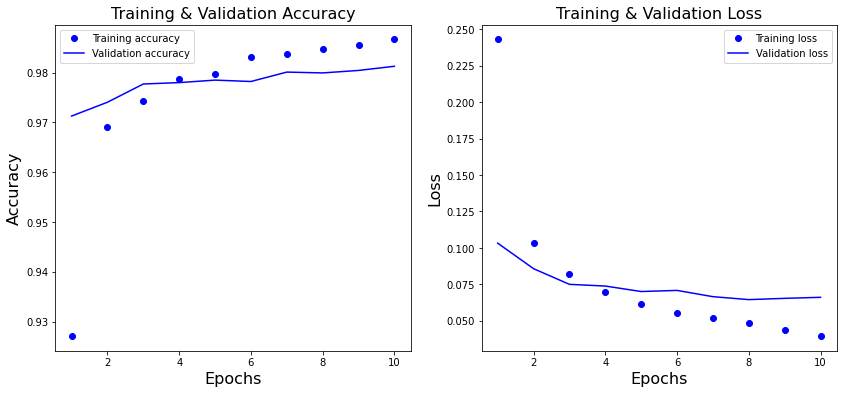

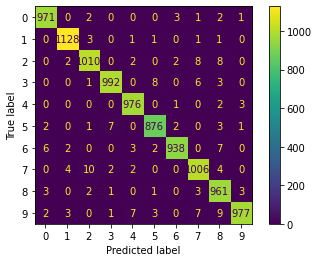

Accuracy
Label 0: 99.08 %
Label 1: 99.38 %
Label 2: 97.87 %
Label 3: 98.22 %
Label 4: 99.39 %
Label 5: 98.21 %
Label 6: 97.91 %
Label 7: 97.86 %
Label 8: 98.67 %
Label 9: 96.83 %
313/313 [==============================] - 1s 4ms/step - loss: 0.0518 - accuracy: 0.9833
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98     

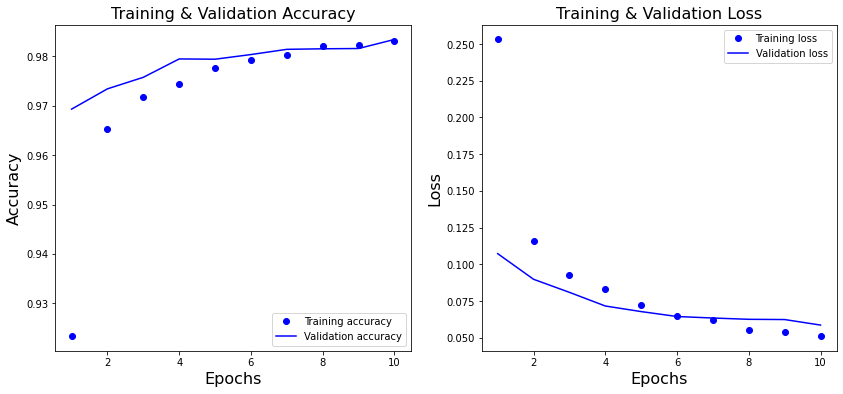

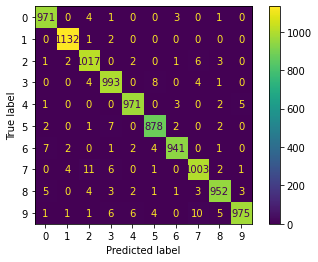

Accuracy
Label 0: 99.08 %
Label 1: 99.74 %
Label 2: 98.55 %
Label 3: 98.32 %
Label 4: 98.88 %
Label 5: 98.43 %
Label 6: 98.23 %
Label 7: 97.57 %
Label 8: 97.74 %
Label 9: 96.63 %
313/313 [==============================] - 1s 5ms/step - loss: 0.0529 - accuracy: 0.9828
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98     

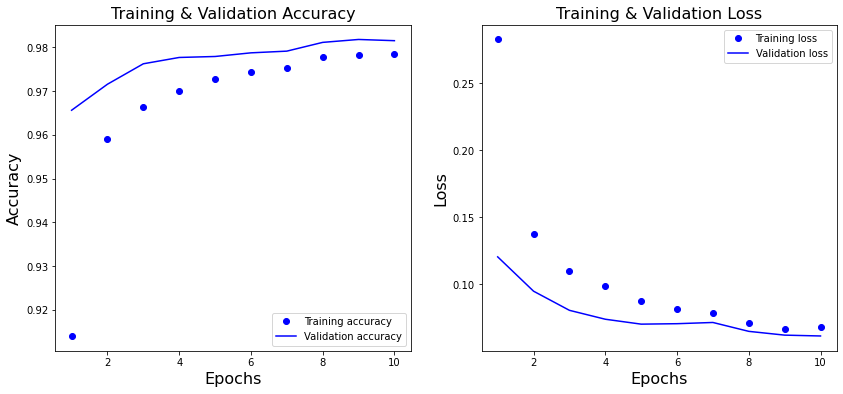

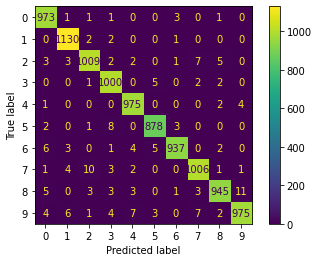

Accuracy
Label 0: 99.29 %
Label 1: 99.56 %
Label 2: 97.77 %
Label 3: 99.01 %
Label 4: 99.29 %
Label 5: 98.43 %
Label 6: 97.81 %
Label 7: 97.86 %
Label 8: 97.02 %
Label 9: 96.63 %
313/313 [==============================] - 1s 4ms/step - loss: 0.0582 - accuracy: 0.9811
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.97      0.98      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98     

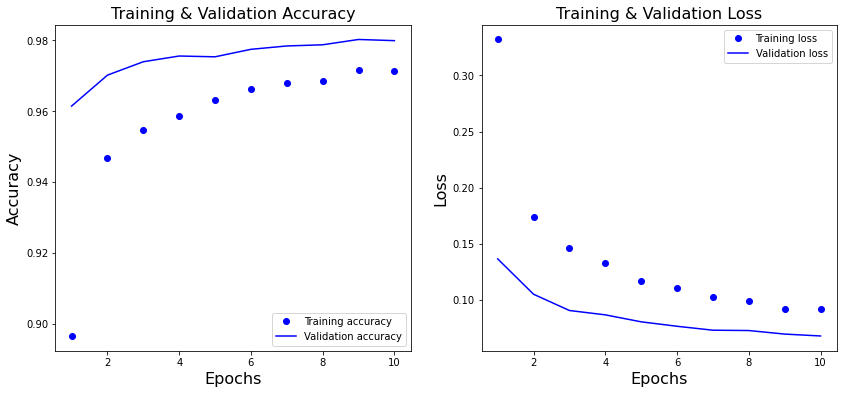

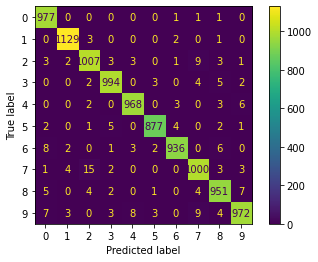

Accuracy
Label 0: 99.69 %
Label 1: 99.47 %
Label 2: 97.58 %
Label 3: 98.42 %
Label 4: 98.57 %
Label 5: 98.32 %
Label 6: 97.70 %
Label 7: 97.28 %
Label 8: 97.64 %
Label 9: 96.33 %
313/313 [==============================] - 1s 5ms/step - loss: 0.0576 - accuracy: 0.9805
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.99       982
           5       0.98      0.99      0.99       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.97      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98     

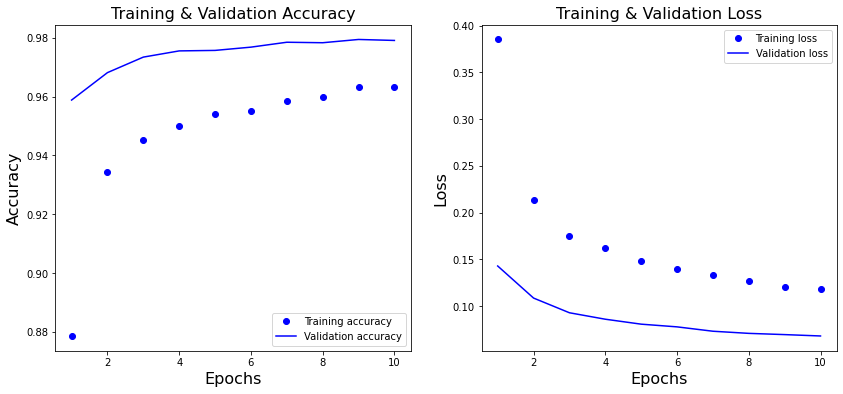

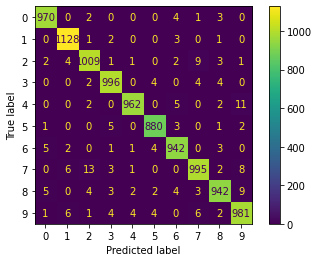

Accuracy
Label 0: 98.98 %
Label 1: 99.38 %
Label 2: 97.77 %
Label 3: 98.61 %
Label 4: 97.96 %
Label 5: 98.65 %
Label 6: 98.33 %
Label 7: 96.79 %
Label 8: 96.71 %
Label 9: 97.22 %


In [ ]:
eval = []
for i in np.arange(0.2, 0.8, 0.1):
  model_CNN_1 = keras.Sequential([
      layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
      layers.MaxPool2D((2, 2)),
      layers.Dropout(i),
      layers.Flatten(),
      layers.Dense(num_class, activation = 'softmax')
  ])
  eval_1, history_1 = networkExperiment(model_CNN_1)
  historyPlot(model_CNN_1, history_1.history, y_test)
  eval.append(eval_1)

#### Resultados

In [ ]:
values = np.arange(0.2, 0.8, 0.1)
for i in range(len(eval)):
  print(("Dropout " + str(values[i]) + " | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval[i][0], percentage1=100*(eval[i][1])))

Dropout 0.2 | Accuracy: 98.30 % | Loss: 0.06
Dropout 0.30000000000000004 | Accuracy: 98.44 % | Loss: 0.05
Dropout 0.4000000000000001 | Accuracy: 98.35 % | Loss: 0.05
Dropout 0.5000000000000001 | Accuracy: 98.33 % | Loss: 0.05
Dropout 0.6000000000000001 | Accuracy: 98.28 % | Loss: 0.05
Dropout 0.7000000000000002 | Accuracy: 98.11 % | Loss: 0.06
Dropout 0.8000000000000003 | Accuracy: 98.05 % | Loss: 0.06



Nesse experimento, nota-se que o melhor efeito regularizador, de acordo com todas as métricas, foi com o dropout de 30%. Assim como no MLP, com o aumento da taxa de dropout, houve a elevação da linha dos valores da função loss na etapa de treinamento, indicando um possível underfitting para valores de dropout altos(70% ou 80%).

### Janela 
#### $(3, 3), (5, 5)$ ou $(7, 7)$

A janela determina o tamanho do filtro convolucional a ser aplicado na entrada. Ela ajuda na diminuição do volume de dados e no aprendizado de características maiores dos dados.


3
313/313 [==============================] - 1s 4ms/step - loss: 0.0720 - accuracy: 0.9819
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.99      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.99      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



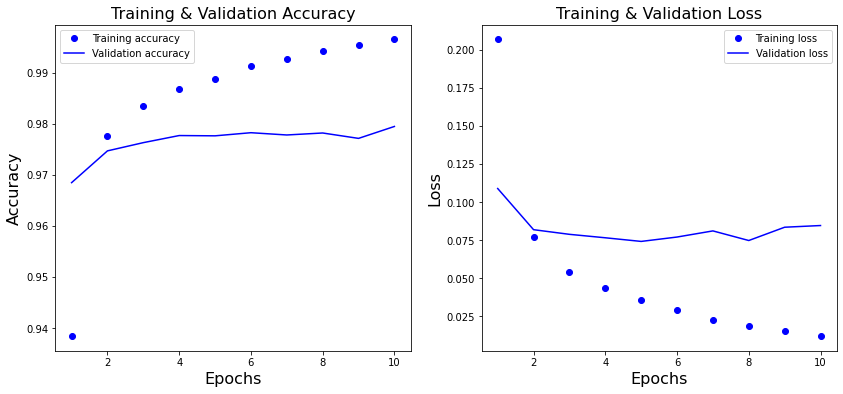

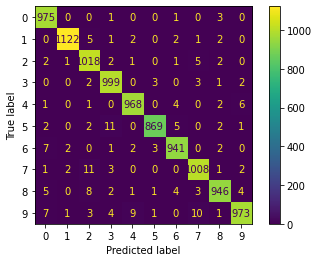

Accuracy
Label 0: 99.49 %
Label 1: 98.85 %
Label 2: 98.64 %
Label 3: 98.91 %
Label 4: 98.57 %
Label 5: 97.42 %
Label 6: 98.23 %
Label 7: 98.05 %
Label 8: 97.13 %
Label 9: 96.43 %
5
313/313 [==============================] - 1s 4ms/step - loss: 0.0567 - accuracy: 0.9841
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.98      0.98      1032
           3       0.99      0.99      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.98       958
           7       0.97      0.99      0.98      1028
           8       0.99      0.97      0.98       974
           9       0.97      0.98      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98   

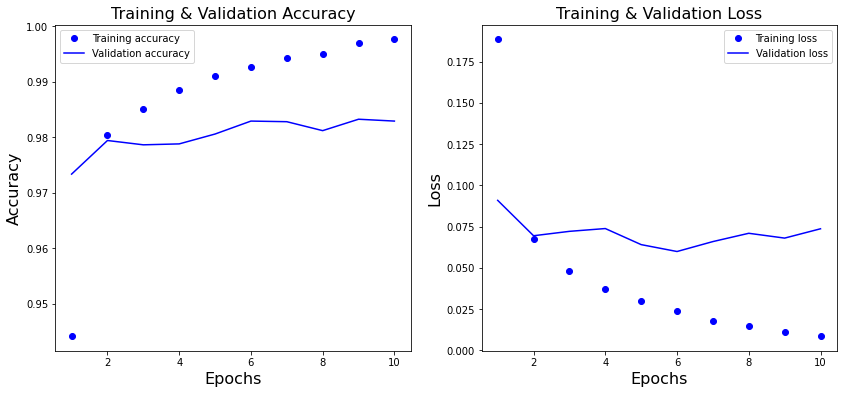

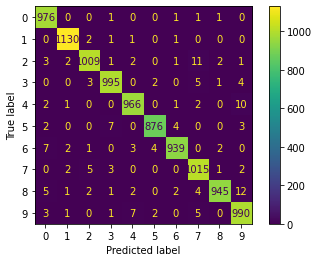

Accuracy
Label 0: 99.59 %
Label 1: 99.56 %
Label 2: 97.77 %
Label 3: 98.51 %
Label 4: 98.37 %
Label 5: 98.21 %
Label 6: 98.02 %
Label 7: 98.74 %
Label 8: 97.02 %
Label 9: 98.12 %
7
313/313 [==============================] - 1s 4ms/step - loss: 0.0420 - accuracy: 0.9892
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       1.00      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99   

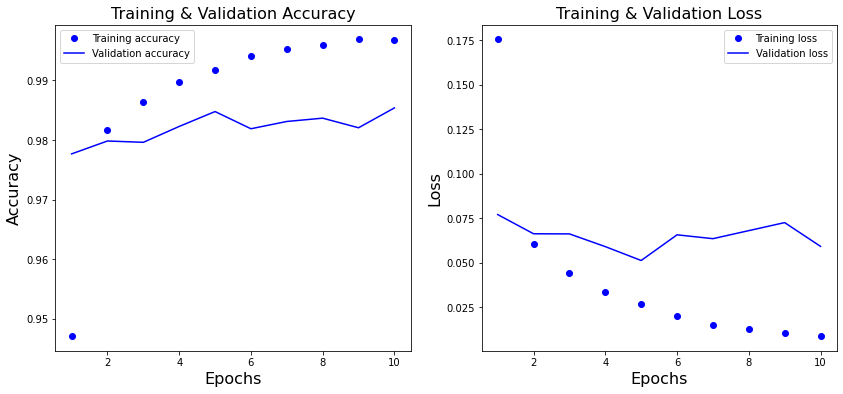

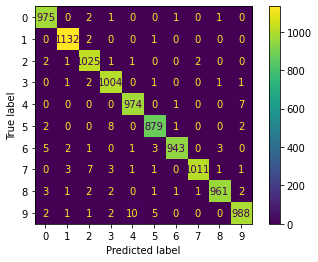

Accuracy
Label 0: 99.49 %
Label 1: 99.74 %
Label 2: 99.32 %
Label 3: 99.41 %
Label 4: 99.19 %
Label 5: 98.54 %
Label 6: 98.43 %
Label 7: 98.35 %
Label 8: 98.67 %
Label 9: 97.92 %


In [ ]:
eval = []
for i in range(3, 8, 2):
  print(i)
  model_CNN_1 = keras.Sequential([
      layers.Conv2D(32, (i, i), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
      layers.MaxPool2D((2, 2)),
      layers.Flatten(),
      layers.Dense(num_class, activation = 'softmax')
  ])
  eval_1, history_1 = networkExperiment(model_CNN_1)
  historyPlot(model_CNN_1, history_1.history, y_test)
  eval.append(eval_1)

#### Resultados

In [ ]:
values = ['(3, 3)', '(5, 5)', '(7, 7)']
for i in range(len(eval)):
  print(("Janela " + str(i) + " | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval[i][0], percentage1=100*(eval[i][1])))

Janela 0 | Accuracy: 98.19 % | Loss: 0.07
Janela 1 | Accuracy: 98.41 % | Loss: 0.06
Janela 2 | Accuracy: 98.92 % | Loss: 0.04


Nesse experimento, vemos que a variação de 3 a 7 no tamanho do filtro na rede tem diferenças pouco relevantes. O filtro que tem o melhor desempenho é o (7,7), mas a precisão, recall e acurácia praticamente não mudam. Logo, os padrões encontrados podem ser detectados tanto por filtros (3,3) quanto por filtros (7,7).


### Stride 
#### $1, 2$ ou $3$

O stride indica o "passo" da convolução ao longo do eixos x e y da entrada inicial. Para o caso de um stride (1, 1):
*   Um dado filtro convolucional é aplicado na posição atual da entrada
*   O filtro da 1 "passo" para direita e aplica novamente o filtro
*   Este processo ocorre até que se chegue à borda direita da entrada em que se moverá 1 "passo" para baixo e retorna para o começo na esquerda

Quanto maior o stride, maior será a redução no tamanho da saída da convolução.


313/313 [==============================] - 1s 4ms/step - loss: 0.0653 - accuracy: 0.9818
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.98      0.98      0.98       892
           6       0.99      0.98      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



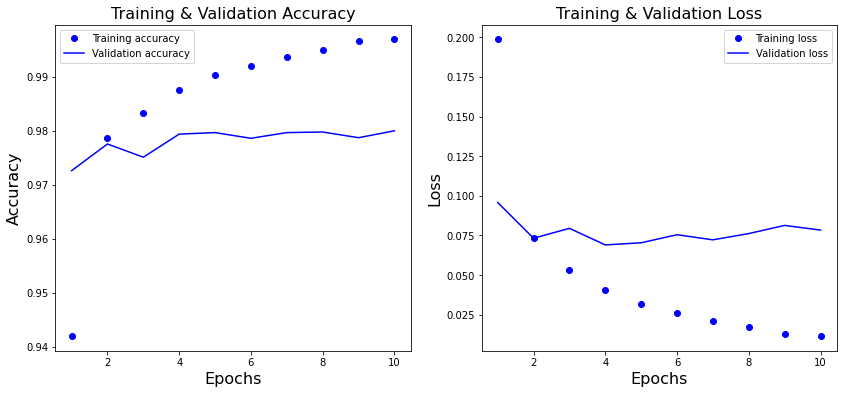

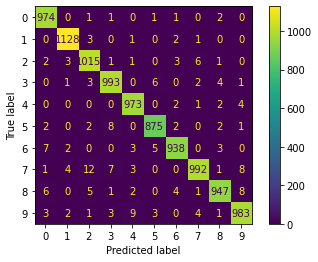

Accuracy
Label 0: 99.39 %
Label 1: 99.38 %
Label 2: 98.35 %
Label 3: 98.32 %
Label 4: 99.08 %
Label 5: 98.09 %
Label 6: 97.91 %
Label 7: 96.50 %
Label 8: 97.23 %
Label 9: 97.42 %
313/313 [==============================] - 1s 4ms/step - loss: 0.0665 - accuracy: 0.9789
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.99      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.98      0.98      0.98       892
           6       0.99      0.97      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.99      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98     

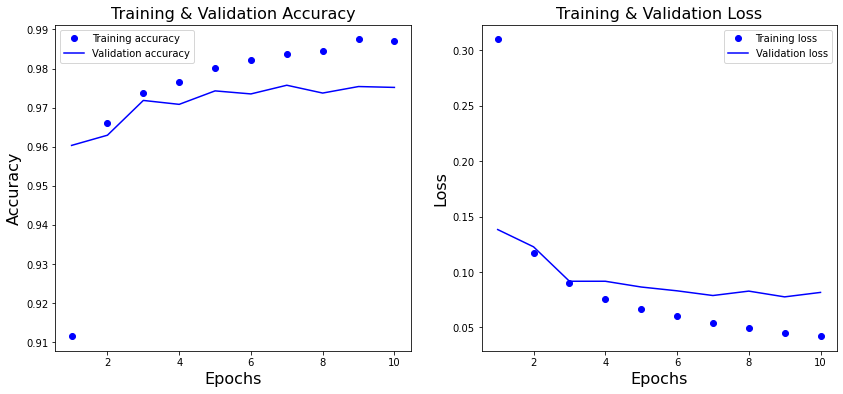

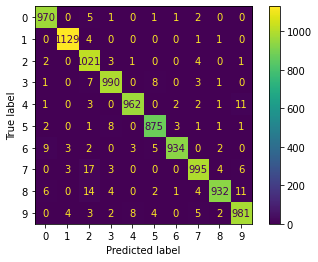

Accuracy
Label 0: 98.98 %
Label 1: 99.47 %
Label 2: 98.93 %
Label 3: 98.02 %
Label 4: 97.96 %
Label 5: 98.09 %
Label 6: 97.49 %
Label 7: 96.79 %
Label 8: 95.69 %
Label 9: 97.22 %
313/313 [==============================] - 1s 4ms/step - loss: 0.1353 - accuracy: 0.9580
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.93      0.95      1010
           4       0.98      0.96      0.97       982
           5       0.93      0.97      0.95       892
           6       0.96      0.97      0.97       958
           7       0.95      0.96      0.95      1028
           8       0.95      0.90      0.93       974
           9       0.95      0.95      0.95      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96     

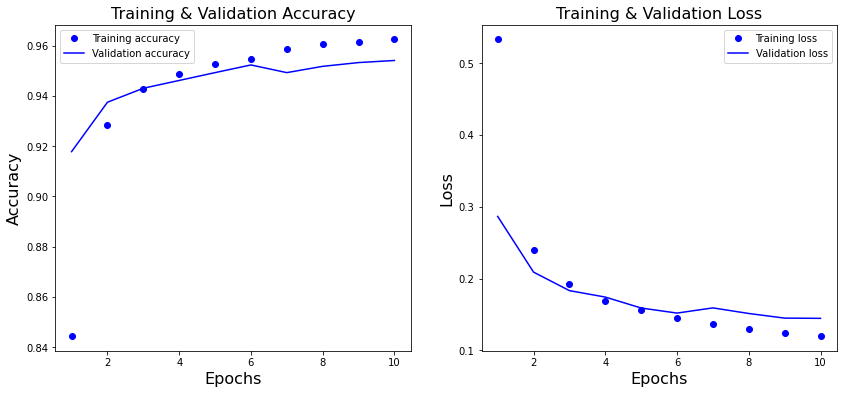

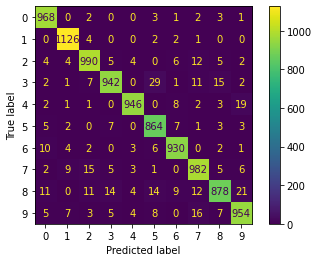

Accuracy
Label 0: 98.78 %
Label 1: 99.21 %
Label 2: 95.93 %
Label 3: 93.27 %
Label 4: 96.33 %
Label 5: 96.86 %
Label 6: 97.08 %
Label 7: 95.53 %
Label 8: 90.14 %
Label 9: 94.55 %


In [ ]:
eval = []
for i in range(1, 4, 1):
  model_CNN_1 = keras.Sequential([
      layers.Conv2D(32, (3, 3), strides = (i, i), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
      layers.MaxPool2D((2, 2)),
      layers.Flatten(),
      layers.Dense(num_class, activation = 'softmax')
  ])
  eval_1, history_1 = networkExperiment(model_CNN_1)
  historyPlot(model_CNN_1, history_1.history, y_test)
  eval.append(eval_1)

#### Resultados

In [ ]:
values = ['(1, 1)', '(2, 2)', '(3, 3)']
for i in range(len(eval)):
  print(("Strides " + values[i] + " | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=eval[i][0], percentage1=100*(eval[i][1])))

Strides (1, 1) | Accuracy: 98.18 % | Loss: 0.07
Strides (2, 2) | Accuracy: 97.89 % | Loss: 0.07
Strides (3, 3) | Accuracy: 95.80 % | Loss: 0.14


Pode notar que o aumento do stride promove uma diminuição da acurácia e um aumento da função loss, uma vez que a imagem é mais comprimida e torna o mapa de características a ser formado mais defasado.

### Análise Final CNN

Assim como no MLP, iremos reunir os melhores valores dos parâmetros em um único modelo e observar sua performance. Além de comparar com o melhor modelo MLP. Os melhores parâmetros foram:

*     Tamanho da rede: 2 camadas
*     Dropout: 30% 
*     Janela: (3, 3)
*     Stride: (1, 1)

313/313 [==============================] - 1s 4ms/step - loss: 0.0388 - accuracy: 0.9877
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.98      0.99      0.98       958
           7       0.98      0.99      0.98      1028
           8       0.99      0.98      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



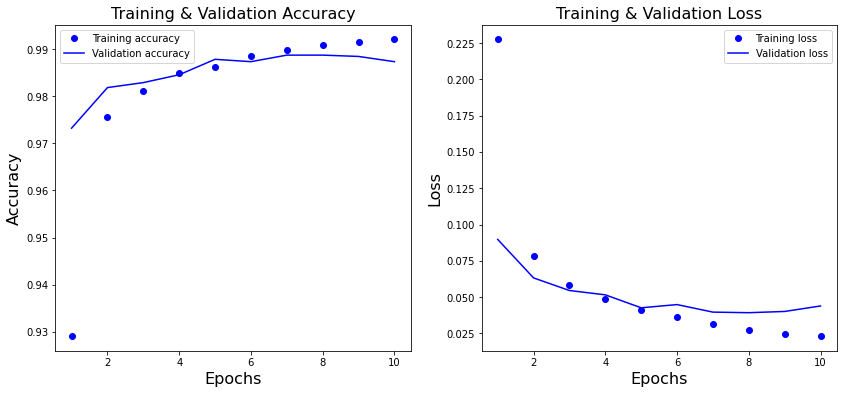

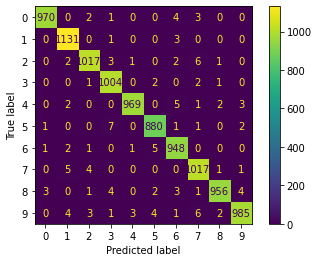

Accuracy
Label 0: 98.98 %
Label 1: 99.65 %
Label 2: 98.55 %
Label 3: 99.41 %
Label 4: 98.68 %
Label 5: 98.65 %
Label 6: 98.96 %
Label 7: 98.93 %
Label 8: 98.15 %
Label 9: 97.62 %


In [ ]:
model_CNN_1 = keras.Sequential([
      layers.Conv2D(32, (3, 3), strides = (1, 1), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
      layers.MaxPool2D((2, 2)),
      layers.Dropout(0.3),
      layers.Conv2D(32, (3, 3), strides = (1, 1), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)),
      layers.MaxPool2D((2, 2)),
      layers.Flatten(),
      layers.Dense(num_class, activation = 'softmax')
])
best_eval_CNN, history_1 = networkExperiment(model_CNN_1)
historyPlot(model_CNN_1, history_1.history, y_test)

In [ ]:
print(("Best CNN Model | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=best_eval_CNN[0], percentage1=100*(best_eval_CNN[1])))

Best CNN Model | Accuracy: 98.77 % | Loss: 0.04


In [ ]:
print(("Best MLP Model | Accuracy: {percentage1:.2f} % | Loss: {percentage2:.2f}").format(percentage2=best_eval_MLP[0], percentage1=100*(best_eval_MLP[1])))

Best MLP Model | Accuracy: 96.84 % | Loss: 0.13


Podemos observar que na tarefa de classificação, o modelo CNN se mostrou melhor, apresentou uma maior acurácia e menor loss apesar do tempo de execução maior comparado ao MLP. A rede neural convolucional se mostra como a rede mais adequada para tarefas que envolvem imagens como a classificação de dígitos com o banco de dados MNIST.